# Итоговый проект. Тема "Промышленность"

Исследование проводится для металлургического комбината "Стальная Птица". Оно потребуется для контроля и реализации возможного уменьшения потребления электроэнергии на этапе обработки стали. Для этого комбинату необходимо контролировать температуру сплава.

**Цель исследования:**
- Построить модель, которая сможет предсказать температуру сплава на этапе обработки стали. Модель потребуется для имитации технологического процесса.

**Ход исследования:**

Данные для исследования получены из следующих файлов:
- данные об электродах, `'https://code.s3.yandex.net/datasets/data_arc_new.csv'`
- данные о подаче сыпучих материалов (объем), `'https://code.s3.yandex.net/datasets/data_bulk_new.csv'`
- данные о подаче сыпучих материалов (время), `'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv'`
- данные о продувке сплава газом, `'https://code.s3.yandex.net/datasets/data_gas_new.csv'`
- результаты измерения температуры, `'https://code.s3.yandex.net/datasets/data_temp_new.csv'`
- данные о проволочных материалах (объем), `'https://code.s3.yandex.net/datasets/data_wire_new.csv'`
- данные о провоочных материалах (время), `'https://code.s3.yandex.net/datasets/data_wire_time_new.csv'`

Поскольку информация о качестве данных отсутствует, то прежде, чем приступать к выполнению целей исследования, потребуется провести предварительную работу. А именно:
- Проверить данные на наличие ошибок, и оценить их влияние на исследование;
- По возможности исправить ошибки так, чтобы они не привели к искажению результатов исследования.

Таким образом, исследование будет проходить в соответствии со следующими этапами:

- Загрузка и обзор данных
- Предобработка данных
- Исследовательский анализ данных
- Корреляционный анализ данных
- Подбор модели для определения температуры сплава
- Подведение итогов исследования

**Примечание:**
- RANDOM_STATE = 160924 - заказчик хочет увидеть качество выполнения проекта при одних и тех же условиях у каждого участника проекта.
- Должна использоваться метрика MAE. Основное требование - MAE на тестовой выборке должно быть не более 6.8
- Целевой признак - последняя измеренная температура партии после добавления всех присадок
- Представленные датасеты должны быть объединены по ключам по принципу - должны остаться данные только по тем партиям, которые есть во всех датафреймах (объединение по типу `inner`).
- Нет задачи построить модель для учета всех сплавов, важно, чтобы она адекватно определяла конечную температуру наиболее часто используемых сплавов.
- Статистические выбросы допустимо убирать только после деления датафрейма на тренировочную и тестовую выборки, но явные аномалии, не соответствующие физическому процессу, допустимо убрать на этапе предобработки данных.
- Разделение на тренировочную и тестовую выборку должно быть 3:1

## Загрузка и обзор данных

### Загрузим необходимые библиотеки, если их нет

In [1]:
!pip uninstall -y scikit-learn -q
!pip install scikit-learn==1.2.0. -q
!pip install matplotlib==3.5.0 -q

In [2]:
!pip install phik -q

In [3]:
!pip install catboost -q

In [4]:
!pip install category_encoders -q

In [5]:
!pip install shap -q

### Импортируем необходимые библиотеки

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import phik
import shap
from phik.report import plot_correlation_matrix


from sklearn.model_selection import train_test_split, GridSearchCV

# импортируем модели
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor


# загружаем нужные классы
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce


# загружаем нужные метрики
from sklearn.metrics import mean_absolute_error

### Загрузим файлы и создадим датафреймы

In [7]:
#Создадим функцию для загрузки файлов
def read_f(name):
    # Создадим датафрейм с информацией о сотрудниках (тренировочная выборка)
    try:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/'+name) 
    except:
        data = pd.read_csv(name)
        
    #Посмотрим его
    print('Датафрейм из файла '+name+' :')
    display(data.head())
    
    print('Информация о датасете '+ name+' :')
    print()
    
    #Посмотрим общую информацию о датафрейме
    print(data.info())
    
    return data

#### Загрузим `'data_arc_new'`

In [8]:
data_arc_new = read_f('data_arc_new.csv')

Датафрейм из файла data_arc_new.csv :


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Информация о датасете data_arc_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


Приведем наименования столбцов к змеиному регистру для удобства работы с данными. Назовем столбцы:
- 'Начало нагрева дугой' - 'start_of_heating'
- 'Конец нагрева дугой' - 'finish_of_heating'
- 'Активная мощность' - 'active_power'
- 'Реактивная мощность' - 'reactive_power'

Столбцы  'start_of_heating' и 'finish_of_heating' приведем к формату временных данных, это дата и время.

In [9]:
#Переименуем столбцы
data_arc_new.columns = ['key', 'start_of_heating', 'finish_of_heating', 'active_power', 'reactive_power']

In [10]:
#Приведем столбы со временем к нужному формату
data_arc_new['start_of_heating'] = pd.to_datetime(data_arc_new['start_of_heating'])
data_arc_new['finish_of_heating'] = pd.to_datetime(data_arc_new['finish_of_heating'])

In [11]:
#Изменим тип данных целых и вещественных чисел для уменьшения занимаемого объема
data_arc_new['key'] = data_arc_new['key'].astype('int32')
data_arc_new['active_power'] = data_arc_new['active_power'].astype('float32')
data_arc_new['reactive_power'] = data_arc_new['reactive_power'].astype('float32')

In [12]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int32         
 1   start_of_heating   14876 non-null  datetime64[ns]
 2   finish_of_heating  14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float32       
 4   reactive_power     14876 non-null  float32       
dtypes: datetime64[ns](2), float32(2), int32(1)
memory usage: 406.9 KB


In [13]:
#Проверим наличие явных дубликатов
data_arc_new.duplicated().sum()

0

Явные дубликаты не обнаружены, а неявных здесь быть не может, поскольку все столбцы так или иначе имеют числовые либо временные значения.

**Итого:**
- Датафрейм `'data_arc_new'` успешно загружен
- Загруженный датафрейм не содержит пропусков и дубликатов
- Столбцы данного датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'float64' и 'int64' были приведены к 'float32' и 'int32' соответственно.

#### Загрузим `'data_bulk_new'`

In [14]:
data_bulk_new = read_f('data_bulk_new.csv')

Датафрейм из файла data_bulk_new.csv :


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

Информация о датасете data_bulk_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


В данном датафрейме много столбцов, у которых много пропущенных значений (больше 10% от общего объема датафрейма - 156 строк), такие столбцы будут малоинформативны при построении модели. Вероятнее всего в данном случае присадки не добавлялись в сплав. Это следующие столбцы:
- Bulk 2
- Bulk 5
- Bulk 7
- Bulk 8
- Bulk 9
- Bulk 13

Поскольку нам не требуется создавать модель, которая могла бы корректно определять конечную температуру каждого вида сплава, допустимо не рассматривать абсолютно все сплавы, и добавление редко используемых присадок можно убрать из обучающих данных.

Создадим новый датафрейм без этих столбцов, приведем названия всех столбцов к змеиному регистру, приведем типы данных к 'int32' и 'float32' соответственно.

In [15]:
#Переименуем колонки
data_bulk_new.columns = [
    'key',
    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
    'bulk_8', 'bulk_9', 'bulk_10','bulk_11','bulk_12', 'bulk_13','bulk_14','bulk_15']

In [16]:
for n_col in range(1,16): 
    data_bulk_new['bulk_'+str(n_col)] = data_bulk_new['bulk_'+str(n_col)].astype('float32')
data_bulk_new['key'] = data_bulk_new['key'].astype('int32')

#Создадим новый датафрейм
data_bulk = data_bulk_new[['key', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15']]

In [17]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int32  
 1   bulk_1   252 non-null    float32
 2   bulk_3   1298 non-null   float32
 3   bulk_4   1014 non-null   float32
 4   bulk_6   576 non-null    float32
 5   bulk_10  176 non-null    float32
 6   bulk_11  177 non-null    float32
 7   bulk_12  2450 non-null   float32
 8   bulk_14  2806 non-null   float32
 9   bulk_15  2248 non-null   float32
dtypes: float32(9), int32(1)
memory usage: 122.4 KB


Осталось еще достаточно много пропущенных значений, заменим их далее на нулевые. Вероятнее всего объем и время добавления сыпучих материалов не указаны в случае, если эти материалы не добавлялись.

Заполним пропуски и проверим наличие дубликатов:

In [18]:
#Проверим наличие явных дубликатов
data_bulk_new.duplicated().sum()

0

In [19]:
#Проверим наличие явных дубликатов
data_bulk.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_bulk_new'` успешно загружен
- Загруженный датафрейм не содержит дубликатов, но содержит много пропусков
- Из загруженного датасета был создан новый датафрейм, из которого были исключены столбцы, в которых пропущенных значений более 5%. В оставшихся столбцах также достаточно много пустых значений, они буду заменены далее на нулевые, поскольку пропущенные значения, очевидно, являются значениями, при которых не добавлялись легирующие компоненты
- Оставшиеся столбцы нового датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'float64' и 'int64' были приведены к 'float32' и 'int32' соответственно.

#### Загрузим `'data_bulk_time_new'`

In [20]:
data_bulk_time_new = read_f('data_bulk_time_new.csv')

Датафрейм из файла data_bulk_time_new.csv :


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Информация о датасете data_bulk_time_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


Очевидно, что этот датасет является продолжением прошлого, и здесь пропуски ровно в тех же строках, поскольку отсутствует время добавления соответствующ х легирующих компонентов. Также создадим новый датафрейм без малозначимых столбцов, в котором приведем типы данных в столбцах в соответствии с их содержанием (в данном случае тип данных всех столбцов, кроме 'key' должен быть 'datetime')

In [21]:
#Переименуем колонки
data_bulk_time_new.columns = [
    'key',
    'bulk_time_1', 'bulk_time_2', 'bulk_time_3', 'bulk_time_4', 'bulk_time_5', 'bulk_time_6', 'bulk_time_7',
    'bulk_time_8', 'bulk_time_9', 'bulk_time_10', 'bulk_time_11', 'bulk_time_12', 'bulk_time_13', 'bulk_time_14', 'bulk_time_15']

In [22]:
for n_col in range(1,16): 
    data_bulk_time_new['bulk_time_'+str(n_col)] = pd.to_datetime(data_bulk_time_new['bulk_time_'+str(n_col)])
data_bulk_time_new['key'] = data_bulk_time_new['key'].astype('int32')

#Создадим новый датафрейм
data_bulk_time = data_bulk_time_new[[
    'key', 
    'bulk_time_1', 'bulk_time_3', 'bulk_time_4', 'bulk_time_6', 'bulk_time_10', 'bulk_time_11', 'bulk_time_12', 'bulk_time_14','bulk_time_15']]

In [23]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int32         
 1   bulk_time_1   252 non-null    datetime64[ns]
 2   bulk_time_2   22 non-null     datetime64[ns]
 3   bulk_time_3   1298 non-null   datetime64[ns]
 4   bulk_time_4   1014 non-null   datetime64[ns]
 5   bulk_time_5   77 non-null     datetime64[ns]
 6   bulk_time_6   576 non-null    datetime64[ns]
 7   bulk_time_7   25 non-null     datetime64[ns]
 8   bulk_time_8   1 non-null      datetime64[ns]
 9   bulk_time_9   19 non-null     datetime64[ns]
 10  bulk_time_10  176 non-null    datetime64[ns]
 11  bulk_time_11  177 non-null    datetime64[ns]
 12  bulk_time_12  2450 non-null   datetime64[ns]
 13  bulk_time_13  18 non-null     datetime64[ns]
 14  bulk_time_14  2806 non-null   datetime64[ns]
 15  bulk_time_15  2248 non-null   datetime

Осталось еще достаточно много пропущенных значений, при необходимости заменим их дальше на нулевые значения, предполгая, что в данном случае легирующие компоненты не добавлялись.

Проверим наличие дубликатов:

In [24]:
#Проверим наличие явных дубликатов
data_bulk_time_new.duplicated().sum()

0

In [25]:
#Проверим наличие явных дубликатов
data_bulk_time.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_bulk_time_new'` успешно загружен
- Загруженный датафрейм не содержит дубликатов, но содержит много пропусков
- Из загруженного датасета был создан новый датафрейм, из которого были исключены столбцы, в которых пропущенных значений более 5%. В оставшихся столбцах также достаточно много пустых значений, они буду заменены далее, поскольку пропущенные значения, очевидно, являются значениями, при которых не добавлялись легирующие компоненты
- Оставшиеся столбцы нового датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'int64' были приведены к 'int32' соответственно, даты приведены к типу datetime.

#### Загрузим `'data_gas_new'`

In [26]:
data_gas_new = read_f('data_gas_new.csv')

Датафрейм из файла data_gas_new.csv :


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Информация о датасете data_gas_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


Данный датасет не содержит пропусков. Переименуем название столбца в соответствии со змеиным регистром, и приведем типы данных к 'float32' и 'int32'

In [27]:
data_gas_new.columns = ['key','gas_1']
data_gas_new['key'] = data_gas_new['key'].astype('int32')
data_gas_new['gas_1'] = data_gas_new['gas_1'].astype('float32')

In [28]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int32  
 1   gas_1   3239 non-null   float32
dtypes: float32(1), int32(1)
memory usage: 25.4 KB


Отлично! Типы данных изменены, наименование столбцов приведено к более удобному виду. Пропусков нет.

Посмотрим наличие дубликатов:

In [29]:
#Проверим наличие явных дубликатов
data_gas_new.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_gas_new'` успешно загружен
- Загруженный датафрейм не содержит пропусков и дубликатов
- Столбцы данного датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'float64' и 'int64' были приведены к 'float32' и 'int32' соответственно.

#### Загрузим `'data_temp_new'`

In [30]:
data_temp_new = read_f('data_temp_new.csv')

Датафрейм из файла data_temp_new.csv :


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

Информация о датасете data_temp_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


Данный датафрейм содержит пропуски в замерах температуры. Поскольку температура - целевой признак, то данные без указанной температуры будут ухудшать точность определения модели.

Создадим новый датафрейм без пропусков, приведем в нем типы данных в столбцах в соответствии с их содержанием.

Заменим наименования столбцов в соответствии с правилами 'змеиного шрифта'

In [31]:
data_temp_new.columns = ['key', 'measurement_time', 'temperature']
data_temp_new['key'] = data_temp_new['key'].astype('int32')
data_temp_new['measurement_time'] = pd.to_datetime(data_temp_new['measurement_time'])
data_temp_new['temperature'] = data_temp_new['temperature'].astype('float32')
data_temp = data_temp_new.dropna()

In [32]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int32         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int32(1)
memory usage: 282.8 KB


Проверим наличие явных дубликатов

In [33]:
#Проверим наличие явных дубликатов
data_temp_new.duplicated().sum()

0

In [34]:
#Проверим наличие явных дубликатов
data_temp.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_temp_new'` успешно загружен
- Столбцы данного датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'float64' и 'int64' были приведены к 'float32' и 'int32' соответственно.
- Загруженный датафрейм не содержит дубликатов, но содержит пропуски в столбце 'Температура'. Поскольку это столбец с целевым признаком, то заполнение пропусков в нем может повлиять на точность модели. Таким образом был создан новый датафрейм без пропусков в целевом признаке.


#### Загрузим `'data_wire_new'`

In [35]:
data_wire_new = read_f('data_wire_new.csv')

Датафрейм из файла data_wire_new.csv :


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

Информация о датасете data_wire_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


В данном датафрейме много столбцов, у которых много пропущенных значений (больше 5% от общего объема датафрейма - 154 строки), такие столбцы будут малоинформативны при построении модели. Вероятнее всего в данном случае присадки не добавлялись в сплав. Это следующие столбцы: Wire 3 - Wire 9

Поскольку нет цели создать модель, прогнозирующую конечную температуру всех производимых справов, столбцы с редкими сплавами можно убрать. Создадим новый датафрейм без этих столбцов, приведем названия столбцов к змеиному регистру, приведем типы данных к 'int32' и 'float32' соответственно.

In [36]:
data_wire_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_new['key'] = data_wire_new['key'].astype('int32')
for n_col in range(1,10):
    data_wire_new['wire_'+str(n_col)] = data_wire_new['wire_'+str(n_col)].astype('float32')

data_wire = data_wire_new[['key', 'wire_1', 'wire_2']]

In [37]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int32  
 1   wire_1  3055 non-null   float32
 2   wire_2  1079 non-null   float32
 3   wire_3  63 non-null     float32
 4   wire_4  14 non-null     float32
 5   wire_5  1 non-null      float32
 6   wire_6  73 non-null     float32
 7   wire_7  11 non-null     float32
 8   wire_8  19 non-null     float32
 9   wire_9  29 non-null     float32
dtypes: float32(9), int32(1)
memory usage: 120.5 KB


В данных датафреймах еще остались пропущенные значения, далее в заменим их на нулевые, поскольку вероятнее всего пропущены значения, в том случае, когда загрузка проволоки не производилась

Проверим наличие дубликатов:

In [38]:
#Проверим наличие явных дубликатов
data_wire_new.duplicated().sum()

0

In [39]:
#Проверим наличие явных дубликатов
data_wire.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_wire_new'` успешно загружен
- Загруженный датафрейм не содержит дубликатов, но содержит много пропусков
- Из загруженного датасета был создан новый датафрейм, из которого были исключены столбцы, в которых пропущенных значений более 5%. В оставшихся столбцах достаточно много пустых значений, они буду заменены далее на нулевые, поскольку пропущенные значения, очевидно, являются значениями, при которых не добавлялась проволока
- Оставшиеся столбцы нового датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'int64' и 'float64' были приведены к 'int32' и 'float32' соответственно.

#### Загрузим `'data_wire_time_new'`

In [40]:
data_wire_time_new = read_f('data_wire_time_new.csv')

Датафрейм из файла data_wire_time_new.csv :


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

Информация о датасете data_wire_time_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


В данном датафрейме много столбцов, у которых много пропущенных значений (больше 5% от общего объема датафрейма - 154 строки). Пропущенные значения в данном датафрейме соответствуют пропущенным значениям в прошлом датафрейме ('data_wire_new'), Wire 3 - Wire 9

Создадим новый датафрейм без этих столбцов, приведем названия столбцов к змеиному регистру, приведем типы данных к 'int32' и 'datetime' в соответствии с их содержимым.

In [41]:
data_wire_time_new.columns = [
    'key',
    'wire_time_1', 'wire_time_2', 'wire_time_3', 'wire_time_4', 'wire_time_5', 'wire_time_6', 'wire_time_7', 'wire_time_8', 'wire_time_9']
data_wire_time_new['key'] = data_wire_time_new['key'].astype('int32')
for n_col in range(1,10):
    data_wire_time_new['wire_time_'+str(n_col)] = pd.to_datetime(data_wire_time_new['wire_time_'+str(n_col)])

data_wire_time = data_wire_time_new[['key', 'wire_time_1', 'wire_time_2']]

In [42]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int32         
 1   wire_time_1  3055 non-null   datetime64[ns]
 2   wire_time_2  1079 non-null   datetime64[ns]
 3   wire_time_3  63 non-null     datetime64[ns]
 4   wire_time_4  14 non-null     datetime64[ns]
 5   wire_time_5  1 non-null      datetime64[ns]
 6   wire_time_6  73 non-null     datetime64[ns]
 7   wire_time_7  11 non-null     datetime64[ns]
 8   wire_time_8  19 non-null     datetime64[ns]
 9   wire_time_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int32(1)
memory usage: 228.8 KB


In [43]:
#Проверим наличие явных дубликатов
data_wire_time_new.duplicated().sum()

0

In [44]:
#Проверим наличие явных дубликатов
data_wire_time.duplicated().sum()

0

**Итого:**
- Датафрейм `'data_wire_time_new'` успешно загружен
- Загруженный датафрейм не содержит дубликатов, но содержит много пропусков, которые соответствуют пропускам в предыдущем датафрейме `'data_wire_new'`
- Из загруженного датасета был создан новый датафрейм, из которого были исключены столбцы, в которых пропущенных значений более 5%. В оставшихся столбцах достаточно много пустых значений, при необходимсоти они буду заменены далее, поскольку пропущенные значения, очевидно, являются значениями, при которых не добавлялась проволока
- Оставшиеся столбцы нового датафрейма для удобства обработки были перееименованы в соответствии с правилами "змеиного шрифта"
- Типы данных в столбцах были приведены в соответствие с их содержанием. Данные типа 'int64' были приведены к 'int32' соответственно, даты приведены к типу datetime.

### Итого

- Были успешно загружены датафреймы `'data_arc_new'`, `'data_bulk_new'`, `'data_bulk_time_new'`, `'data_gas_new'`, `'data_temp_new'`, `'data_wire_new'`, `'data_wire_time_new'`
- Названия столбцов у всех датафреймов для удобства обработки были приведены к змеиному шрифту
- Типы данных в столбцах датафреймов были приведены в соответствие с их содержимым. Кроме того, данные типа `'float64'` и `'int64'` были приведены к `'float32'` и `'int32'` соответственно.
- Все датафреймы не содержат дубликаты, но некоторые из них содержат пропуски.
- Некоторые столбцы в датафреймах `'data_bulk_new'`, `'data_bulk_time_new'`, `'data_wire_new'` и `'data_wire_time_new'` содержат крайне мало заполненных значений (менее 5%). Таки столбцы будут малоинформативны при построении модели, поэтому они были удалены. в дальнейшем `'data_bulk_new'` и `'data_bulk_time_new'`, а также `'data_wire_new'` и `'data_wire_time_new'` имеет смысл объединить, чтобы выяснить, есть ли зависимость между добавлением определенных присадок и температурой нагрева.
- В датафрейме `'data_temp_new'` также содержалось значительное количество пропусков в столбце с температурой. Поскольку этот столбец является целевым признаком, то строки с пропусками в данном столбце пришлось удалить, несмотря на то, что их достаточно много.
- Полноценные исходные файлы также могут быть использованы.

## Исследовательский анализ данных

### Посмотрим данные об электродах, они находятся в датафрейме `'data_arc_new'`

In [45]:
data_arc_new.describe()

key  active_power  reactive_power
count  14876.000000  14876.000000    14876.000000
mean    1615.220422      0.662752        0.438986
std      934.571502      0.258885        5.873485
min        1.000000      0.223120     -715.479919
25%      806.000000      0.467115        0.337175
50%     1617.000000      0.599587        0.441639
75%     2429.000000      0.830070        0.608201
max     3241.000000      1.463773        1.270284

Можно заметить, что:
- значения в столбце key содержат значения от 1 до 3241. Таким образом, есть информация о нагреве 3240 партий деталей.
- в столбце 'reactive_power' содержится как минимум одно отрицательное значение. Отрицательной мощности быть не может. это явная аномалия. Посмотрим, что это за партия.

In [46]:
data_arc_new.query('reactive_power<0')

key    start_of_heating   finish_of_heating  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479919

In [47]:
#Посмотрим, какой разбросреактивной мощности у всех партий с похожей активной мощностью
data_arc_new.query('0.705<active_power<0.706 and reactive_power>0')['reactive_power'].describe()

count    15.000000
mean      0.513887
std       0.047473
min       0.443546
25%       0.485020
50%       0.500482
75%       0.529704
max       0.620895
Name: reactive_power, dtype: float64

Процессов плавления с похожей активной мощностью 15, медианное значение реактивной мощности для них составляет 0.500482, а разброс между первой и третьей квартилью достаточно небольшая. Заменим наше отрицательное значение на полученное медианное значение.

In [48]:
median_re_power = data_arc_new.query('0.705<active_power<0.706 and reactive_power>0')['reactive_power'].describe()['50%']
data_arc_new.loc[data_arc_new.query('reactive_power<0').index,'reactive_power'] = median_re_power

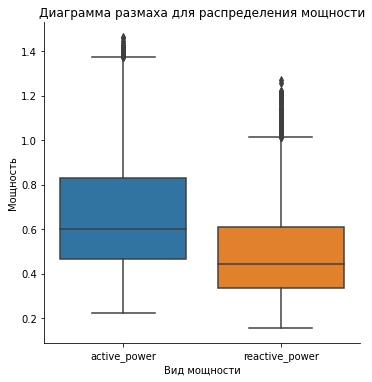

In [49]:
#Посмотрим диаграмму размаха
sns.catplot(kind="box", data=data_arc_new[['active_power', 'reactive_power']])
plt.title('Диаграмма размаха для распределения мощности')
plt.xlabel('Вид мощности')
plt.ylabel('Мощность')
plt.show()

В оставшихся значениях датафрейма не осталось заметных выбросов, есть только некоторое количество достаточно высоких значений мощности.

Вспомним понятие активной и реактивной мощности. Активная мощность - это мощность которая уходит на полезную нагрузку, реактивная - та, которая поглощается или вырабатывается генератором. В целом по сети распространяется полная мощность. Полная мощность определяется как корень квадратный от суммы квадратов мощностей. Полная мощность может быть дополнительным признаком. Создадим столбец 'full_power', возможно он пригодится при проведении дальнейшего анализа.

In [50]:
data_arc_new['full_power'] = (data_arc_new['active_power']**2+data_arc_new['reactive_power']**2)**(1/2)

Посмотрим плотность распределения мощности:

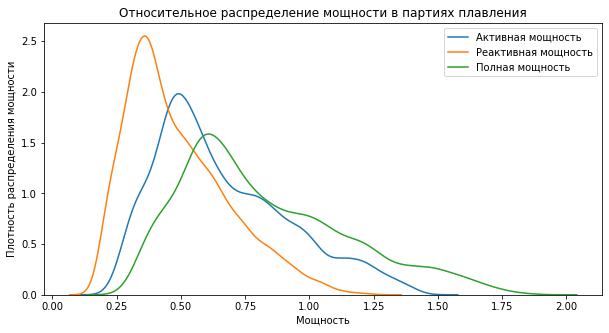

In [51]:
#Посмотрим плотность распределения
plt.figure(figsize=(10,5))
sns.kdeplot(
    data = data_arc_new['active_power'],
    label = 'Активная мощность'
    )
sns.kdeplot(
    data = data_arc_new['reactive_power'], 
    label = 'Реактивная мощность')
sns.kdeplot(
    data = data_arc_new['full_power'], 
    label = 'Полная мощность')
plt.legend(loc=1)
plt.title('Относительное распределение мощности в партиях плавления')
plt.ylabel('Плотность распределения мощности')
plt.xlabel('Мощность')
plt.show()

Можно заметить, что:
- В среднем активная мощность больше реактивной, следовательно большая часть полной мощности все-таки расходуется на полезную работу.
- Ряд операций по легированию сплавов требуют больше мощности и, вероятно, выше температуры. Но в целом таких операций меньше, а активная мощность на такие операции тратиться больше, чем реактивная. 
- Кажется, что операции, на которые расходуется сравнительно больше активной мощности, могут быть более эффективными с точки зрения экономии электроэнергии.

Поскольку все-таки более важна информация о длительности нагрева, а не о начале и конце нагрева, то имеет смысл заменить два столбца со временем начала и конца нагрева на один, длительность нагрева в секундах. Добавим новый столбец в датафрейм.

In [52]:
data_arc_new['time_power'] = data_arc_new['finish_of_heating'] - data_arc_new['start_of_heating']
data_arc_new['time_power'] = data_arc_new['time_power'].astype('timedelta64[s]').astype('float32')

Посмотрим распределение времени нагрева

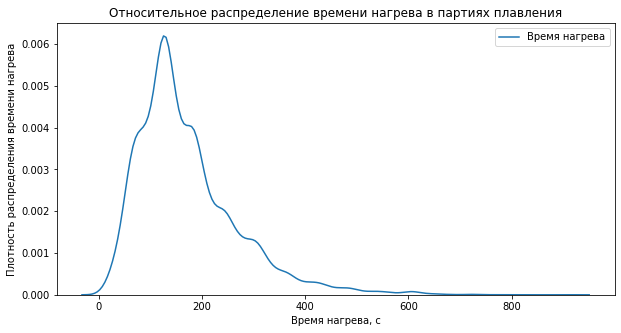

In [53]:
#Посмотрим плотность распределения
plt.figure(figsize=(10,5))
sns.kdeplot(
    data = data_arc_new['time_power'],
    label = 'Время нагрева'
    )
plt.legend(loc=1)
plt.title('Относительное распределение времени нагрева в партиях плавления')
plt.ylabel('Плотность распределения времени нагрева')
plt.xlabel('Время нагрева, с')
plt.show()

Можно заметить, что в большинстве случаев время негрева составляет от 2 до 3.5 минут. Посмотрим, так ли это?

In [54]:
data_arc_new['time_power'].describe()

count    14876.000000
mean       171.670944
std         98.186806
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_power, dtype: float64

Действительно, большая часть операций требует от 107 до 214с нагрева, медианное значение - порядка 147с, а среднее больше - 171.67с нагрева. Такая разница возникает из-за того, что есть варианты легирования, при которых требуется более долгий нагрев сплава.

Минимальное время нагрева составляет 11с, а максимальное - 907с.

Посмотрим. не является ли ато аномальным выбросом?

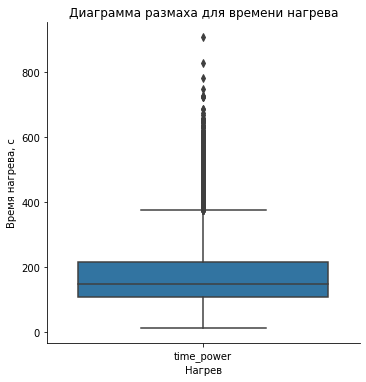

In [55]:
#Посмотрим диаграмму размаха
sns.catplot(kind="box", data=data_arc_new[['time_power']])
plt.title('Диаграмма размаха для времени нагрева')
plt.xlabel('Нагрев')
plt.ylabel('Время нагрева, с')
plt.show()

Все-таки основная часть операций требует времени нагрева до 700с, остальные операции редкие. Далее, после объединения данных в одну таблицу, возможно имеет смысл посмотреть, какие операции требуют больше всего времени нагрева.

Создадим новый датафрейм, наиболее удобный для дальнейшего анализа - удалим из имеющегося лишние столбцы, которые были уже использованы для создания нового признака - время начала и конца нагрева.

In [56]:
data_arc = data_arc_new.drop(['finish_of_heating','start_of_heating'], axis=1)

In [57]:
data_arc.describe()

key  active_power  reactive_power    full_power    time_power
count  14876.000000  14876.000000    14876.000000  14876.000000  14876.000000
mean    1615.220422      0.662752        0.487116      0.823387    171.670944
std      934.571502      0.258885        0.197606      0.323459     98.186806
min        1.000000      0.223120        0.153777      0.275718     11.000000
25%      806.000000      0.467115        0.337192      0.578847    107.000000
50%     1617.000000      0.599587        0.441667      0.746591    147.000000
75%     2429.000000      0.830070        0.608201      1.030390    214.000000
max     3241.000000      1.463773        1.270284      1.898158    907.000000

**Итого:**
- Отрицательное значение реактивной мощности в одной строке было заменено на медианное значение реактивной мощности среди партий, активная мощность процессов плавления которых была близка по значению.
- Создан новый датафрейм `'data_arc'`, включающий в себя дополнительные признаки `'full_power'` (полная мощность) и `'time_power'` (время нагрева в с), из которого были удалены ненужные уже столбцы с началом и окончанием нагрева.
- Большая часть операций легирования требует полной мощности от 0.578839 до 1.030402. медианное значение полной мощности составляет 0.746554, а среднее - 0.823384. Среднее знаение мощности немного больше, поскольку часть операций требует повышенной мощности. При этом следует отметить, что после значений активной мощности порядка 0.7, активная мощность начинает немного больше превышать реактивную, кажется, что полезная работа совершается более эффективно. Кажется, что операции, на которые расходуется сравнительно больше активной мощности, могут быть более эффективными с точки зрения экономии электроэнергии.
- В среднем активная мощность больше реактивной, следовательно большая часть полной мощности все-таки расходуется на полезную работу.
.
- Большая часть операций требует от 107 до 214с нагрева, медианное значение - порядка 147с, а среднее больше - 171.67с нагрева. Такая разница возникает из-за того, что есть варианты легирования, при которых требуется более долгий нагрев сплава. 
Минимальное время нагрева составляет 11с, а максимальное - 907с.

### Посмотрим данные о продувке сплава газом, они находятся в датафрейме `'data_gas_new'`

In [58]:
data_gas_new.describe()

key        gas_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769916
max    3241.000000    77.995041

Можно заметить, что объем подаваемого газа в большинстве случаев составляет от 7.043 до 13.769, но в некоторых случаях может достигать значений 77.99. Минимальное значение объема подаваемого газа - 0.008

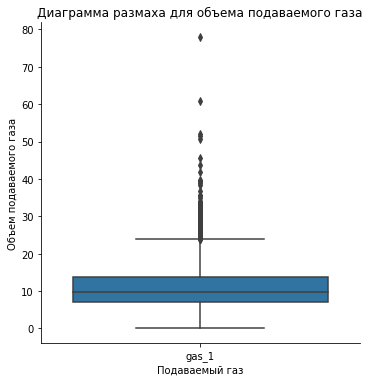

In [59]:
#Посмотрим диаграмму размаха
sns.catplot(kind="box", data=data_gas_new[['gas_1']])
plt.title('Диаграмма размаха для объема подаваемого газа')
plt.xlabel('Подаваемый газ')
plt.ylabel('Объем подаваемого газа')
plt.show()

Большие значения объема подаваемого газа действительно достаточно редкие.

Посмотрим плотность распределения:

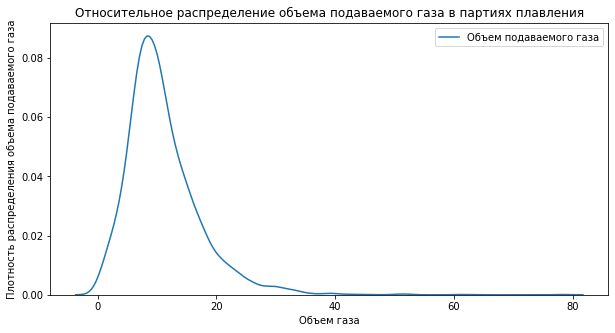

In [60]:
#Посмотрим плотность распределения
plt.figure(figsize=(10,5))
sns.kdeplot(
    data = data_gas_new['gas_1'],
    label = 'Объем подаваемого газа'
    )
plt.legend(loc=1)
plt.title('Относительное распределение объема подаваемого газа в партиях плавления')
plt.ylabel('Плотность распределения объема подаваемого газа')
plt.xlabel('Объем газа')
plt.show()

Больше похоже на нормальное распределение, хотя немного - на распределение Пуассона, с небольшим вторым пиком в районе 30.

Здесь кажется, что значения больше 40 действительно являются выбросами - редкими случаями. После разделения на тренировочную и тестовую выборку их можно будет удалить из тренировочной выборки или заменить значение объема газа на условно 'предельное' - 40.

**Итого:**
- Большая часть операций требует объема газа от 7.04 до 13.77. медианное значение объема газа составляет 9.84, а среднее - 11.00 Среднее знаение мощности существенно больше, поскольку часть операций требует сравнительно большего объема.
- Плотность распределения объема подаваемого газа больше похожа на распределение Пуассона, близкое к нормальному. Значения объемов подаваемого газа больше 40 больше похожи на выбросы. После разделения датасета на тренировочную и тестовую выборку их можно будет удалить из тренировочной выборки, или заменить значение объема газа на условно 'предельное' - 40.

### Посмотрим результаты измерения температуры, они находятся в датафрейме `'data_temp_new'`

Напомню, что в датафрейме `'data_temp_new'` содержатся данные о времени и, собственно, температуре. Посмотрим распределение температуры:

In [61]:
data_temp_new.describe()

key   temperature
count  18092.000000  14665.000000
mean    1616.460977   1590.722778
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

Большая часть процессов требует нагрева до 1580-1599 градусов. Медианное значение 1590, а среднее - 1590.72, они достаточно близки. Это говорит о том, что отклонений от среднего совсем немного, и больше отклонений в сторону увеличения.

Посмотрим, так ли это: 

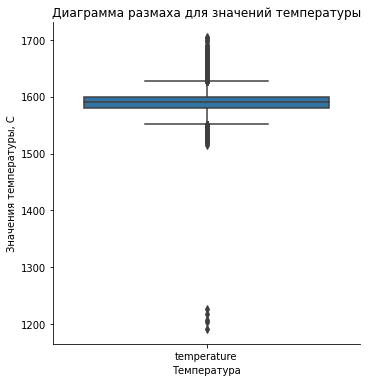

In [62]:
#Посмотрим диаграмму размаха
sns.catplot(kind="box", data=data_temp_new[['temperature']])
plt.title('Диаграмма размаха для значений температуры')
plt.xlabel('Температура')
plt.ylabel('Значения температуры, С')
plt.show()

Нагрев до температур менее 1300 градусов кажется аномальным, таких значений температуры совсем немного. Значения температуры от 1500 градусов до 1700 кажутся вариантами нормы для различных процессов легирования. Уберем из ранее обработанного датафрейма `'data_temp'` значения температур менее 1300 градусов.

In [63]:
data_temp = data_temp.query('temperature>1300')

Посмотрим распределение температур в новом файле `'data_temp'`

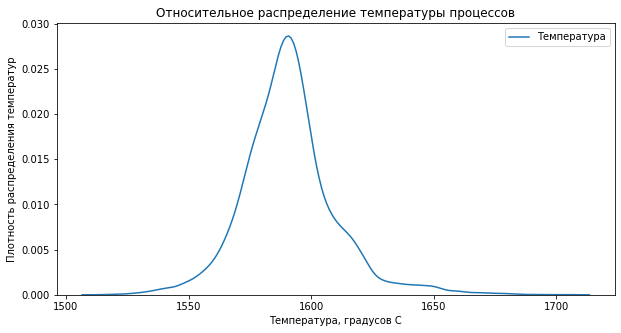

In [64]:
#Посмотрим плотность распределения
plt.figure(figsize=(10,5))
sns.kdeplot(
    data = data_temp['temperature'],
    label = 'Температура'
    )
plt.legend(loc=1)
plt.title('Относительное распределение температуры процессов')
plt.ylabel('Плотность распределения температур')
plt.xlabel('Температура, градусов С')
plt.show()

Из распределения температур процессов видно, что большинство процессов требуют температур порядка 1590 градусов, но также заметно, что есть ряд процессов легирования, которые требуют повышенных температур. Кажется, что это те же процессы, которые были заметны и на распределении плотностей мощностей. Возможно, данные процессы можно было бы отследить в данных по объему и времени засыпки сыпучих веществ, а также по данным о загрузке проволоки.

Распределение также близкое к нормальному, с одним дополнительным пиком в области пониженных температур и двумя дополнительными пиками в области повышенных температур.

Посмотрим распределение времени по индексам строки в таблице измерения температур

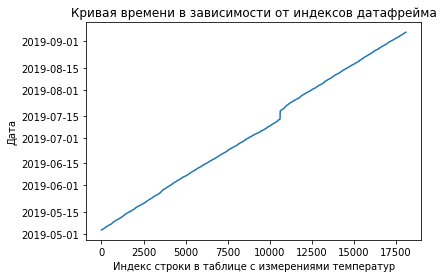

In [65]:
data_temp_new['measurement_time'].plot()
plt.title('Кривая времени в зависимости от индексов датафрейма')
plt.ylabel('Дата')
plt.xlabel('Индекс строки в таблице с измерениями температур')
plt.show()

Можно заметить, что в некоторый период времени замеры температуры не проводились, возможно был простой в производстве.

Посмотрим распределение замеров температур по временной шкале:

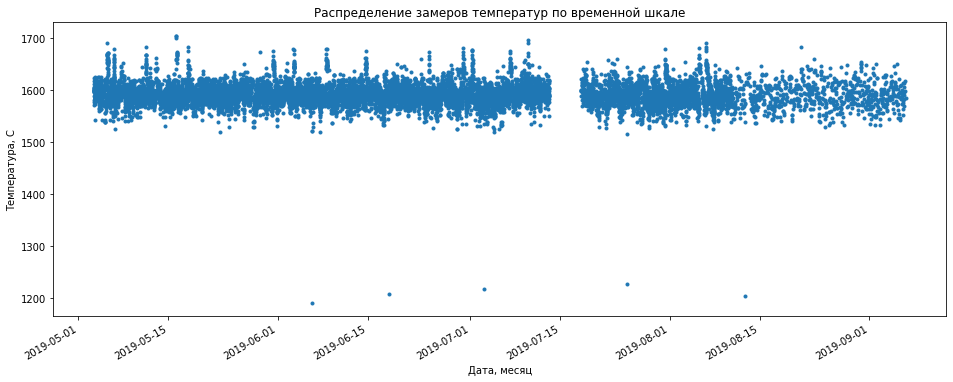

In [66]:
#Посмотрим зависимость температуры от времени
data_temp_new.set_index('measurement_time')['temperature'].plot(figsize=(16, 6), style = '.')
plt.title('Распределение замеров температур по временной шкале')
plt.ylabel('Температура, С')
plt.xlabel('Дата, месяц')
plt.show()

Действительно, можно заметить. что некоторое время температура сплавов не замерялась. Либо был простой оборудования, либо неисправность термодатчиков, что сомнительно, поскольку изменения не проводились в течение нескольих дней.

Также можно заметить, что в определенный момент, видимо, поменялась технология производства сплавов, либо возникли проблемы с работой термодатчиков. Поскольку частота измерения температуры изменилась, теперь не каждое значение времени замера соответствует температуре, в некоторые моменты времени температурные показания отсутствуют.  Если это не намеренное отсутсвие замера температуры, возможно возникло нарушение работоспособности одного из термодатчиков, либо нарушение в процессе записи данных. Этот момент рекомендуется уточнить.

Можно посмотреть, когда произошло изменение замеров температуры:

In [67]:
data_temp_new[data_temp_new['temperature'].isna()].head()

key    measurement_time  temperature
13927  2500 2019-08-10 14:13:11          NaN
13928  2500 2019-08-10 14:18:12          NaN
13929  2500 2019-08-10 14:25:53          NaN
13930  2500 2019-08-10 14:29:39          NaN
13932  2501 2019-08-10 14:49:15          NaN

Нарушение замеров температуры впервые возникло 10 августа 2019 года в 14:13

**Итого:**
- Из нового датафрейма `'data_temp'`, были удалены строки с температурами менее 1300 С. Практически все процессы требуют нагрева от 1500 до 1700 С, температуры ниже 1300С кажутся аномальными, поскольку температура плавления стали 1300-1500 градусов по Цельсию.
- Большая часть процессов требует нагрева до 1580-1599 градусов. Медианное значение 1590, а среднее - 1590.72.
- Распределение температур также близкое к нормальному, с одним дополнительным пиком в области пониженных температур и двумя дополнительными пиками в области повышенных температур.
- В некоторый период времени замеры температуры не проводились, возможно был простой в производстве.
- Начиная с 10 августа 2019 года (14:13) наблюдаются нарушения в записи замеров температуры. Либо поменялась технология производства сплавов, либо возникли проблемы с работой термодатчиков. С этого момента не каждое значение времени замера соответствует температуре, в некоторые моменты времени температурные показания отсутствуют. Если это не намеренное отсутсвие замера температуры, то возможно возникло нарушение работоспособности одного из термодатчиков, либо нарушение в процессе записи данных. Этот момент рекомендуется уточнить.

### Посмотрим данные о добавлении сыпучих и проволочных материалов из датафреймов `'data_bulk_new'`, `'data_bulk_time_new'`, `'data_wire_new'`, `'data_wire_time_new'`

#### Объединим данные о добавлении сыпучих материалов из датафреймов `'data_bulk_new'`, `'data_bulk_time_new'`

In [68]:
bulk_new = data_bulk_new.merge(data_bulk_time_new, on='key')
bulk_new.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  ...  bulk_time_6  bulk_time_7  bulk_time_8  bulk_time_9  \
0     NaN  ...          NaT          NaT          NaT          NaT   
1     NaN  ...          NaT          NaT          NaT          NaT   
2     NaN  ...          NaT          NaT          NaT          NaT   
3     NaN  ...          NaT          NaT          NaT          NaT   
4     NaN  ...          NaT          NaT          NaT          NaT   

   bulk_time_10  bulk_time_11        bulk_time_12 bulk_time_13  \
0           NaT           NaT 2019-05-03 11:24:31          NaT   
1           NaT           NaT 2019-05-03 11:53:30          NaT   
2           NaT           NaT 2019-05-03 12:27:13          NaT   
3           NaT           NaT 2019-05-03 12:58:00          NaT   
4           NaT           NaT 2019-05-03 13:30:47          NaT   

         bulk_time_14        bulk_time_15  
0 2019-05-03 11:14:50 2019-05-03 11:10:43  
1 2019-05-03 11:48:37 2019-05-03 11:44:39  
2 2019-05-03 12:21:01 2019-05-03 12:16:16  
3 2019-05-03 12:51:11 2019-05-03 12:46:36  
4 2019-05-03 13:34:12 2019-05-03 13:30:47  

[5 rows x 31 columns]

Для удобства дальнейшего анализа создадим новый датафрейм, который будет состоять из четырех столбцов - ключа `'key'`, объема сыпучего материала `'bulk_volume'`, времени подачи сыпучего материала `'bulk_time'` и номера процесса подачи материала от 1 до 15.

Посмотрим получившийся датафрейм.

In [69]:
bulk = pd.DataFrame()
for n_col in range(1,16):
    df = pd.DataFrame()
    df['key'] = bulk_new['key']
    df['bulk_volume'] = bulk_new['bulk_'+str(n_col)]
    df['bulk_time'] = bulk_new['bulk_time_'+str(n_col)]
    df['n_proc_bulk'] = n_col
    df = df.dropna()
    bulk = pd.concat([bulk,df])

bulk.reset_index(drop=True, inplace=True)
bulk.head()

key  bulk_volume           bulk_time  n_proc_bulk
0   12         46.0 2019-05-03 17:42:46            1
1   57         27.0 2019-05-05 16:26:52            1
2   58         48.0 2019-05-05 17:18:36            1
3   59         29.0 2019-05-05 18:32:50            1
4   60         46.0 2019-05-05 19:34:07            1

Посмотрим общую информацию о получившемся датафрейме:

In [70]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          11159 non-null  int32         
 1   bulk_volume  11159 non-null  float32       
 2   bulk_time    11159 non-null  datetime64[ns]
 3   n_proc_bulk  11159 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1)
memory usage: 261.7 KB


Таким образом, новый датафрейм содержит информацию об объемах используемых сыпучих материалов, распределенных по партиям и по номерам процессов добавления сыпучих материалов.

Можно посмотреть распределение объемов сыпучих материалов для различных процессов

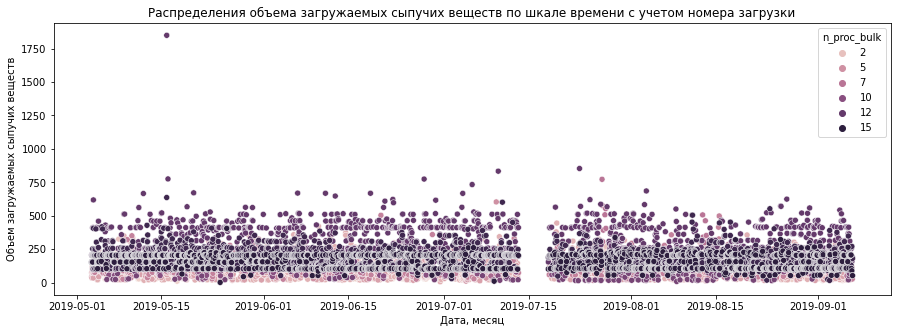

In [71]:
#Посмотрим распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки
plt.figure(figsize=(15,5))
sns.scatterplot(data=bulk, x='bulk_time', y='bulk_volume', hue='n_proc_bulk')
plt.title('Распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки')
plt.ylabel('Объем загружаемых сыпучих веществ')
plt.xlabel('Дата, месяц')
plt.show()

Можно заметить:
- Один явный выброс - один раз были добавлены сыпучие вещества в аномально большом количестве
- Сыпучие вещества в загрузках 'bulk_14' и 'bulk_15' подаются объемами обычно не менее определенного значения
- Сыпучие вещества в загрузках 'bulk_3'-'bulk_4' подаются практически любого объема

Посмотрим более подробно участок производства от начала до 10 августа, когда возникли обнаруженные изменения в замерах температуры. Для наглядности ограничим заодно график и по объему загружаемых сыпучих веществ.

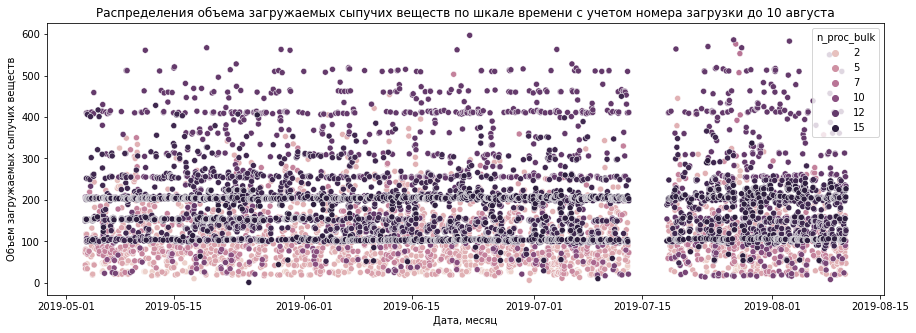

In [72]:
#Посмотрим распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки
plt.figure(figsize=(15,5))
sns.scatterplot(data=bulk[(bulk['key']<2500) & (bulk['bulk_volume']<600)], x='bulk_time', y='bulk_volume', hue='n_proc_bulk')
plt.title('Распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки до 10 августа')
plt.ylabel('Объем загружаемых сыпучих веществ')
plt.xlabel('Дата, месяц')
plt.show()

Здесь можно заметить, что:
- До определенного момента в загрузках 'bulk_14' и 'bulk_15' загружался объем сыпучих веществ, более 100 (примерно до 250) и кратный 50, заргузки ненормированного объема наблюдались реже. Менее 100 загружались сыпучие материалы в загрузках 'bulk_3' и 'bulk_4'. Кажется, что такие загрузки в целом не нормированы.
- После определенного момента загрузки 'bulk_14' и 'bulk_15' начали более часто использоваться, и объем загружаемых в эти загрузки веществ практически перестал нормироваться.
- Тот самый 'определенный момент' не совпадает с 10 августа, он наступил несколько раньше, а именно 28 июля 2019 года:

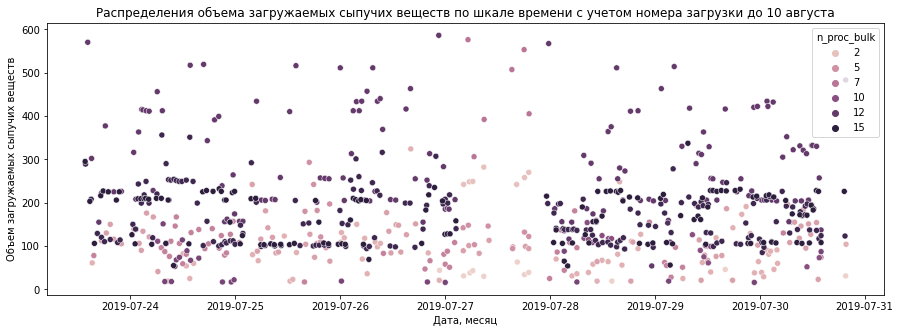

In [73]:
#Посмотрим распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки
plt.figure(figsize=(15,5))
sns.scatterplot(data=bulk[(bulk['key']>2000) & (bulk['key']<2200) & (bulk['bulk_volume']<600)], x='bulk_time', y='bulk_volume', hue='n_proc_bulk')
plt.title('Распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки до 10 августа')
plt.ylabel('Объем загружаемых сыпучих веществ')
plt.xlabel('Дата, месяц')
plt.show()

Интересно было бы посмотреть, как повлияли изменения от 27 июля и от 10 августа на потребляемую мощность. Кажется, что техпроцесс действительно изменился.

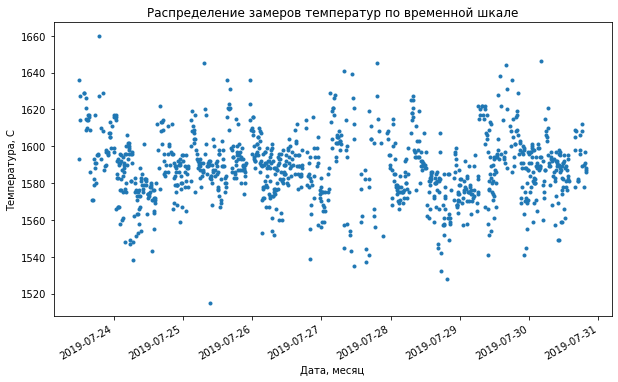

In [74]:
#Посмотрим зависимость температуры от времени
data_temp_new.set_index('measurement_time').query('key<2200 and key>2000 and temperature>1500')['temperature'].plot(figsize=(10, 6), style = '.')
plt.title('Распределение замеров температур по временной шкале')
plt.ylabel('Температура, С')
plt.xlabel('Дата, месяц')
plt.show()

Да, заметно увеличилась дисперсия при измерении температуры.

#### Объединим данные о добавлении проволоки из датафреймов `'data_wire_new'`, `'data_wire_time_new'`

In [75]:
wire_new = data_wire_new.merge(data_wire_time_new, on='key')
wire_new.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160156      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238235  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9         wire_time_1         wire_time_2 wire_time_3 wire_time_4  \
0     NaN 2019-05-03 11:06:19                 NaT         NaT         NaT   
1     NaN 2019-05-03 11:36:50                 NaT         NaT         NaT   
2     NaN 2019-05-03 12:11:46                 NaT         NaT         NaT   
3     NaN 2019-05-03 12:43:22                 NaT         NaT         NaT   
4     NaN 2019-05-03 13:20:44 2019-05-03 13:15:34         NaT         NaT   

  wire_time_5 wire_time_6 wire_time_7 wire_time_8 wire_time_9  
0         NaT         NaT         NaT         NaT         NaT  
1         NaT         NaT         NaT         NaT         NaT  
2         NaT         NaT         NaT         NaT         NaT  
3         NaT         NaT         NaT         NaT         NaT  
4         NaT         NaT         NaT         NaT         NaT

Для удобства дальнейшего анализа создадим новый датафрейм, который будет состоять из четырех столбцов - ключа 'key', объема подаваемых проволочных материалов 'wire_volume', времени подачи сыпучего материала 'wire_time' и номера процесса подачи материала от 1 до 9.

Посмотрим получившийся датафрейм.

In [76]:
wire = pd.DataFrame()
for n_col in range(1,10):
    df = pd.DataFrame()
    df['key'] = wire_new['key']
    df['wire_volume'] = wire_new['wire_'+str(n_col)]
    df['wire_time'] = wire_new['wire_time_'+str(n_col)]
    df['n_proc_wire'] = n_col
    df = df.dropna()
    wire = pd.concat([wire,df])

wire.reset_index(drop=True, inplace=True)
wire.head()

key  wire_volume           wire_time  n_proc_wire
0    1    60.059998 2019-05-03 11:06:19            1
1    2    96.052315 2019-05-03 11:36:50            1
2    3    91.160156 2019-05-03 12:11:46            1
3    4    89.063515 2019-05-03 12:43:22            1
4    5    89.238235 2019-05-03 13:20:44            1

Посмотрим общую информацию о получившемся датафрейме:

In [77]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          4344 non-null   int32         
 1   wire_volume  4344 non-null   float32       
 2   wire_time    4344 non-null   datetime64[ns]
 3   n_proc_wire  4344 non-null   int64         
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1)
memory usage: 101.9 KB


Таким образом датафрейм содержит информацию об объемах используемых проволочных материалов, распределенных по партиям и по номерам процессов добавления проволочных материалов.

Можно посмотреть распределение объемов проволочных материалов для различных процессов

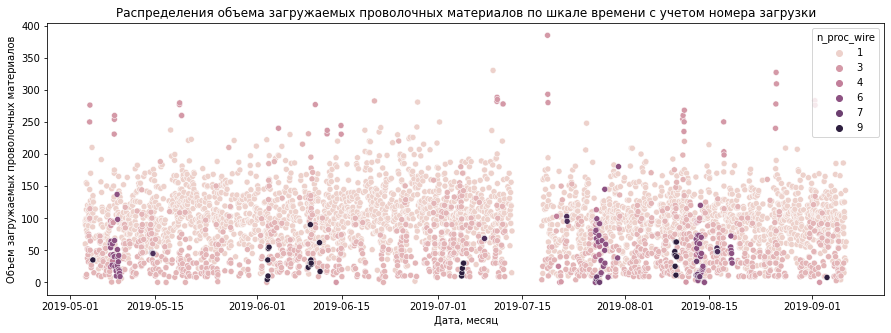

In [78]:
#Посмотрим распределения объема загружаемых сыпучих веществ по шкале времени с учетом номера загрузки
plt.figure(figsize=(15,5))
sns.scatterplot(data=wire, x='wire_time', y='wire_volume', hue='n_proc_wire')
plt.title('Распределения объема загружаемых проволочных материалов по шкале времени с учетом номера загрузки')
plt.ylabel('Объем загружаемых проволочных материалов')
plt.xlabel('Дата, месяц')
plt.show()

Здесь тоже можно заметить некоторое изменение технологическог процесса в тех же временных интервалах, что и при добавлении сыпучих присадок. До определенного момента использовались в основном загрузки 'wire_1' и 'wire_2', крайне редко - 'wire_9', остальные загрузки практически не использовались. После 27 июля начали чаще использоваться загрузки 'wire_3'-'wire_8'.

#### Объединим данные о добавлении сыпучих и проволочных материалов из датафреймов `'bulk'` и `'wire'`

In [79]:
bulk.columns = ['key', 'volume', 'time', 'n_proc']
wire.columns = ['key', 'volume', 'time', 'n_proc']

Чтобы не перепутались загрузки сыпучих и проволочных материалов, добавим к столбцу 'n_proc ' в датафрейме 'wire' число 15 (последний номер загрузки сыпучих материалов)

In [80]:
wire['n_proc'] = wire['n_proc'] + 15

Объединим два датафрейма в один 'additives' и отсортируем его по ключу и по времени.

In [81]:
additives = pd.concat([bulk,wire])
additives = additives.sort_values(by=['key','time']).reset_index(drop=True)
additives.head(10)

key      volume                time  n_proc
0    1   60.059998 2019-05-03 11:06:19      16
1    1  154.000000 2019-05-03 11:10:43      15
2    1  150.000000 2019-05-03 11:14:50      14
3    1  206.000000 2019-05-03 11:24:31      12
4    1   43.000000 2019-05-03 11:28:48       4
5    2   73.000000 2019-05-03 11:36:50       4
6    2   96.052315 2019-05-03 11:36:50      16
7    2  154.000000 2019-05-03 11:44:39      15
8    2  149.000000 2019-05-03 11:48:37      14
9    2  206.000000 2019-05-03 11:53:30      12

Отлично. Информация о добавлениях материалов последовательно с учетом времени собрана в один файл. Пришла пора вспомнить, как протекает техпроцесс.

#### Итого

- Все датафреймы, несущие информацию о легировании сплавов выли объединены в один, отсортированный по номеру партии по времени добавления легирующего вещества.
- По данным добавления легирующих веществ также было обнаружено изменение технологического процесса:
    - До определенного момента в загрузках 'bulk_14' и 'bulk_15' загружался объем сыпучих веществ, более 100 (примерно до 250) и кратный 50, заргузки ненормированного объема наблюдались реже. Менее 100 загружались сыпучие материалы в загрузках 'bulk_3' и 'bulk_4'. Кажется, что такие загрузки в целом не нормированы.
    - После определенного момента загрузки 'bulk_14' и 'bulk_15' начали более часто использоваться, и объем загружаемых в эти загрузки веществ практически перестал нормироваться.
    - Тот самый 'определенный момент' не совпадает с 10 августа, он наступил несколько раньше, а именно 28 июля 2019 года (начиная с 2111 партии).
    - При загрузке проволоки до определенного момента использовались в основном загрузки 'wire_1' и 'wire_2', крайне редко - 'wire_9', остальные загрузки практически не использовались. После 27 июля начали чаще использоваться загрузки 'wire_3'-'wire_8'.

### Попробуем восстановить последовательнось процесса каждой партии создания сплава и сопоставить его с полученными датафреймами

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Таким образом процесс выплавления определенног сплава состоит из следующих этапов:
1. Измерение температуры
2. Нагрев электродами
3. Добавление легирующих материалов
6. Продув газом
7. Измерение температуры и состава
8. Далее повторять, начиная с п. 3 до получения необходимого химического состава

Таким образом количество измерений температуры должно быть на одно больше, чем количество нагревов электродами, а количество продувок газом должно соответствовать легированиям.

Посмотрим, так ли это:

In [82]:
print('Количество нагревов электродов: ', data_arc_new['key'].count())
print('Количество запросов о температуре: ', data_temp_new['key'].count())
print('Количество информативных запросов о температуре: ', data_temp_new[~data_temp_new['temperature'].isna()]['key'].count())

Количество нагревов электродов:  14876
Количество запросов о температуре:  18092
Количество информативных запросов о температуре:  14665


Кажется, что полученных значений температуры явно не хватает.

Вспомним, что начиная с 2500 партии появились пропуски в измерениях температуры, возможно в этом кроется несоответствие? Сравним запросы температуры и нагревы электродов до 10 августа и после:

In [83]:
print('Количество нагревов электродов до 10 августа: ', data_arc_new[data_arc_new['key']<2500]['key'].count())
print('Количество запросов о температуре до 10 августа: ', data_temp_new[data_temp_new['key']<2500]['key'].count())
print('Количество партий, выплавленных до 10 августа: ', data_arc_new[data_arc_new['key']<2500]['key'].unique().shape[0])
print(
    'Разница между количеством запросов температур и количеством нагревов до 10 августа:',
    data_temp_new[data_temp_new['key']<2500]['key'].count()-data_arc_new[data_arc_new['key']<2500]['key'].count()
)

Количество нагревов электродов до 10 августа:  11449
Количество запросов о температуре до 10 августа:  13926
Количество партий, выплавленных до 10 августа:  2475
Разница между количеством запросов температур и количеством нагревов до 10 августа: 2477


Количество запросов практически соответствует количеству нагревов плюс один. Возможно дополнительных запросы были выполнены при определении аномально низкой температуры. Даже если это случайные дополнительные измерения, произошедшие, например, из-за паузы в процессе производства, то 3 дополнительных замера при таком количестве измерений - немного. Таким образом установлена технология производства сплавов до 10 августа.

Посмотрим, как выглядел техпроцесс до 10 августа:

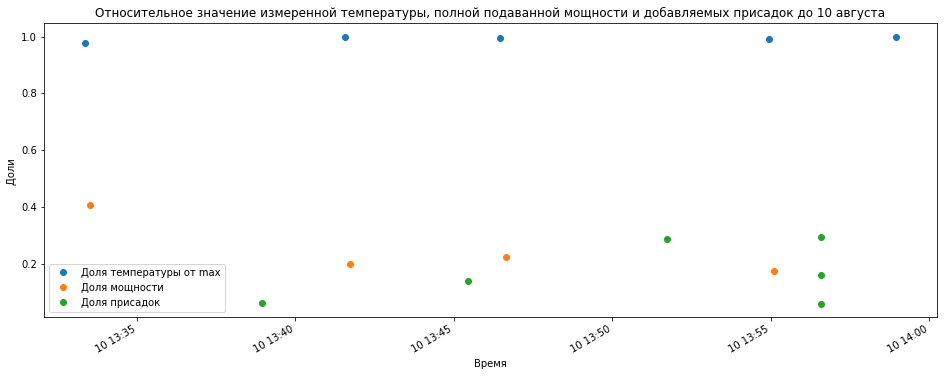

In [84]:
#Посмотрим распределение по временной шкале событий для одного из вариантов процессов создания сплава
temp_before = data_temp_new.set_index('measurement_time').query('key == 2499')['temperature']
temp_before = temp_before/temp_before.max()
arc_before = data_arc_new.set_index('start_of_heating').query('key == 2499')['full_power']
arc_before = arc_before/arc_before.sum()
add_before = additives.set_index('time').query('key == 2499')['volume']
add_before = add_before/add_before.sum()
temp_before.plot(figsize=(16, 6), style = 'o', label = 'Доля температуры от max')
arc_before.plot(figsize=(16, 6), style = 'o', label = 'Доля мощности')
add_before.plot(figsize=(16, 6), style = 'o', label = 'Доля присадок')
plt.title('Относительное значение измеренной температуры, полной подаванной мощности и добавляемых присадок до 10 августа')
plt.legend(loc=3)
plt.ylabel('Доли ')
plt.xlabel('Время')
plt.show()

In [85]:
print('Количество нагревов электродов после 10 августа: ', data_arc_new[data_arc_new['key']>=2500]['key'].count())
print(
    'Количество эффективных запросов о температуре после 10 августа: ', 
    data_temp_new[(data_temp_new['key']>=2500)&(~data_temp_new['temperature'].isna())]['key'].count())
print('Количество партий, выплавленных после 10 августа: ', data_arc_new[data_arc_new['key']>=2500]['key'].unique().shape[0])

Количество нагревов электродов после 10 августа:  3427
Количество эффективных запросов о температуре после 10 августа:  739
Количество партий, выплавленных после 10 августа:  739


In [86]:
#Посмотрим разброс измеренных температур за этот период
data_temp_new[(data_temp_new['key']>=2500)&(~data_temp_new['temperature'].isna())].describe()

key  temperature
count   739.000000   739.000000
mean   2869.852503  1589.216553
std     213.963364    28.826069
min    2500.000000  1204.000000
25%    2685.500000  1573.000000
50%    2870.000000  1588.000000
75%    3054.500000  1607.000000
max    3241.000000  1684.000000

Таким образом получается, что после 10 августа 2019 года температуру начали измерять один раз за время изготовления партии, не контролируя температуру сплава в процессе. Внимание, вопрос: не произошло ли из-за этого нарушение технологии создания сплавов определенного состава, были ли произведен контроль химического состава и качества выплавляемых заготовок.

Вот так выглядел техпроцесс после 10 августа:

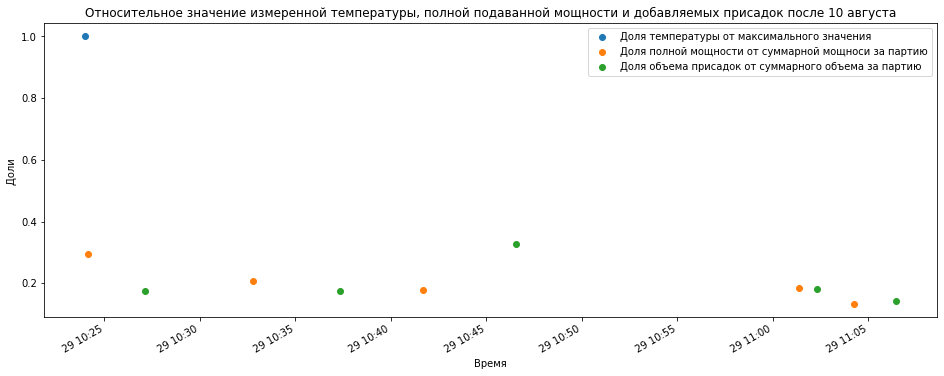

In [87]:
#Посмотрим распределение по временной шкале событий для одного из вариантов процессов создания сплава
temp_before = data_temp_new.set_index('measurement_time').query('key == 3001')['temperature']
temp_before = temp_before/temp_before.max()
arc_before = data_arc_new.set_index('start_of_heating').query('key == 3001')['full_power']
arc_before = arc_before/arc_before.sum()
add_before = additives.set_index('time').query('key == 3001')['volume']
add_before = add_before/add_before.sum()
temp_before.plot(figsize=(16, 6), style = 'o', label = 'Доля температуры от максимального значения')
arc_before.plot(figsize=(16, 6), style = 'o', label = 'Доля полной мощности от суммарной мощноси за партию')
add_before.plot(figsize=(16, 6), style = 'o', label = 'Доля объема присадок от суммарного объема за партию')
plt.title('Относительное значение измеренной температуры, полной подаванной мощности и добавляемых присадок после 10 августа')
plt.legend(loc=1)
plt.ylabel('Доли ')
plt.xlabel('Время')
plt.show()

In [88]:
print(
    'Первое и единственное измерение температуры после 10 августа для случайной партии произошло в: ',
    data_temp_new.query('key == 3001')['measurement_time'].min())
print(
    'Первое включение электродов после 10 августа для этой же случайной партии произошло в: ',
    data_arc_new.query('key == 3001')['start_of_heating'].min())

Первое и единственное измерение температуры после 10 августа для случайной партии произошло в:  2019-08-29 10:23:59
Первое включение электродов после 10 августа для этой же случайной партии произошло в:  2019-08-29 10:24:09


Получается, что первое и единственное измерение температуры после 10 августа производилось в самом начале техпроцесса.

**Таким образом данные, начиная с 10 августа 2019 года (номер партии 2500) не могут быть использованы для разработки модели машинного обучения, предсказывающей конечную температуру расплава. Все данные о партиях 2500 и старше придется исключить из дальнейшего анализа**

**Итого:**
- По исходным данным была восстановлена последовательность техпроцессов производства стали двух временных периодов - до 10 августа 2019 года и после 10 августа 2019 года. Было обнаружено нарушение техпроцесса после 10 августа 2019 года, а именно:  первое и единственное измерение температуры производилось в самом начале процесса производства, дальнейшие замеры температуры не фиксировались. Возможно произошел отказ соответствующих термодатчиков либо отказ в системе записи данных. Рекомендуется данную информацию проверить.
- Из-за нарушения процесса контролирования температурных режмов при изготовлении стали могли произойти нарушения температурных режимов создания сплавов определенного состава. Рекомендуется уточнить, был ли произведен контроль химического состава и качества (технических характеристик) выплавляемых заготовок.
- Информация по производству партий сплавов, начиная номера партии 2500, не может быть использована для обучения модели МО, предсказывающей конечную температуру расплава. Все данные о партиях 2500 и старше придется исключить из дальнейшего анализа.

### Итого

**Результаты анализа целевого признака:**
- Большая часть процессов требует нагрева до 1580-1599 градусов. Медианное значение 1590, а среднее - 1590.72.
- Распределение температур близкое к нормальному, с одним дополнительным пиком в области пониженных температур и двумя дополнительными пиками в области повышенных температур.
- Начиная с 10 августа 2019 года (14:13) наблюдаются нарушения в записи замеров температуры. Либо поменялась технология производства сплавов, либо возникли проблемы с работой термодатчиков. С этого момента не каждое значение времени замера соответствует температуре, в некоторые моменты времени температурные показания отсутствуют. Если это не намеренное отсутсвие замера температуры, то возможно возникло нарушение работоспособности одного из термодатчиков, либо нарушение в процессе записи данных.

**Статистика по входным признакам:**

- Большая часть операций легирования требует полной мощности от 0.578839 до 1.030402. медианное значение полной мощности составляет 0.746554, а среднее - 0.823384. Среднее знаение мощности немного больше, поскольку часть операций требует повышенной мощности. При этом следует отметить, что после значений активной мощности порядка 0.7, активная мощность начинает немного больше превышать реактивную, кажется, что полезная работа совершается более эффективно. Кажется, что операции, на которые расходуется сравнительно больше активной мощности, могут быть более эффективными с точки зрения экономии электроэнергии. В среднем активная мощность больше реактивной, следовательно большая часть полной мощности все-таки расходуется на полезную работу.
- Большая часть операций требует от 107 до 214с нагрева, медианное значение - порядка 147с, а среднее больше - 171.67с нагрева. Такая разница возникает из-за того, что есть варианты легирования, при которых требуется более долгий нагрев сплава. Минимальное время нагрева составляет 11с, а максимальное - 907с.
- Большая часть операций требует объема газа от 7.04 до 13.77. медианное значение объема газа составляет 9.84, а среднее - 11.00 Среднее значение мощности существенно больше, поскольку часть операций требует сравнительно большего объема. Плотность распределения объема подаваемого газа больше похожа на распределение Пуассона, близкое к нормальному.
- По данным добавления легирующих веществ также было обнаружено изменение технологического процесса:
    - До определенного момента в загрузках 'bulk_14' и 'bulk_15' загружался объем сыпучих веществ, более 100 (примерно до 250) и кратный 50, заргузки ненормированного объема наблюдались реже. Менее 100 загружались сыпучие материалы в загрузках 'bulk_3' и 'bulk_4'. Кажется, что такие загрузки в целом не нормированы.
    - После определенного момента загрузки 'bulk_14' и 'bulk_15' начали более часто использоваться, и объем загружаемых в эти загрузки веществ практически перестал нормироваться.
    - Тот самый 'определенный момент' не совпадает с 10 августа, он наступил несколько раньше, а именно 28 июля 2019 года (начиная с 2111 партии).
    - При загрузке проволоки до определенного момента использовались в основном загрузки 'wire_1' и 'wire_2', крайне редко - 'wire_9', остальные загрузки практически не использовались. После 27 июля начали чаще использоваться загрузки 'wire_3'-'wire_8'.


**Исходные датафреймы были очищены от аномалий и дополнены:**
- Из нового датафрейма `'data_temp'`, были удалены строки с температурами менее 1300 С. Практически все процессы требуют нагрева от 1500 до 1700 С, температуры ниже 1300С кажутся аномальными, поскольку температура плавления стали 1300-1500 градусов по Цельсию.
- В датафрейме `'data_arc_new'` отрицательное значение реактивной мощности в одной строке было заменено на медианное значение реактивной мощности среди партий, активная мощность процессов плавления которых была близка по значению.
- Создан новый датафрейм `'data_arc'`, включающий в себя дополнительные признаки `'full_power'` (полная мощность) и `'time_power'` (время нагрева в с), из которого были удалены столбцы с началом и окончанием нагрева.
- Значения объемов подаваемого газа больше 40 больше похожи на выбросы. При необходимости, после разделения итогового датасета на тренировочную и тестовую выборку, их можно будет удалить из тренировочной выборки.

**Рекомендации:**
- По исходным данным была восстановлена последовательность техпроцессов производства стали двух временных периодов - до 10 августа 2019 года и после 10 августа 2019 года. Было обнаружено нарушение техпроцесса после 10 августа 2019 года, а именно:  первое и единственное измерение температуры производилось в самом начале процесса производства, дальнейшие замеры температуры не фиксировались. Возможно произошел отказ соответствующих термодатчиков либо отказ в системе записи данных. Рекомендуется проверить работоспособность температурных датчиков и корректность процессов записи температуры.
- Помимо нарушения процесса фиксации температуры также было обнаружено изменение процессов добавления легирующих веществ, которое наблюдается с 28 июля 2019 года (партия 2111). Рекомендуется обратить внимание на объемы загружаемых сыпучих веществ в загрузках 'bulk_14' и 'bulk_15' и проволоки в загрузках 'wire_3'-'wire_8'. Если не было значительных изменений в марках сплавов данных партий, возможно был нарушен процесс загрузки присадок.

**Примечание:**
- Из-за нарушения процесса контролирования температурных режмов при изготовлении стали могли произойти нарушения температурных режимов создания сплавов определенного состава. Рекомендуется уточнить, был ли произведен контроль химического состава и качества (технических характеристик) выплавляемых заготовок.
- Информация по производству партий сплавов, начиная номера партии 2500, не может быть использована для обучения модели МО, предсказывающей конечную температуру расплава. Все данные о партиях 2500 и старше придется исключить из дальнейшего анализа.

## Объединение признаков в общую таблицу и анализ итогового датафрейма.

### Создадим дополнительные признаки и объединим исходные датафреймы в один

In [89]:
#Посмотрим информацию об итоговом датафрейме
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14660 non-null  int32         
 1   measurement_time  14660 non-null  datetime64[ns]
 2   temperature       14660 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int32(1)
memory usage: 343.6 KB


Согласно требованию заказчика, нам нужно спрогнозировать итоговую температуру при производстве партии стали, поэтому создадим датафрейм с итоговыми температурами. В качестве входных признаков можно добавить следующие дополнительные признаки:
- Длительность процесса (в нашем случае это разница между первым и последним временем замера).
- Начальную температуру (с ней связаны другие входные признаки, такие как потраченная мощность или время нагрева)

In [90]:
data_temp = data_temp.sort_values(by=['key','measurement_time']).reset_index(drop=True)
temp = []
keys = []
duration = []
temp_1 = []
for k in data_temp['key'].unique():
    df = data_temp[data_temp['key']==k].copy()
    if df['key'].count()>1:
        max_time = df['measurement_time'].max()
        min_time = df['measurement_time'].min()
        temp.append(float(df.loc[df['measurement_time']==max_time]['temperature'].values))
        temp_1.append(float(df.loc[df['measurement_time']==min_time]['temperature'].values))
        keys.append(k)
        duration.append(df['measurement_time'].max()-df['measurement_time'].min())

temp = pd.DataFrame({'key':keys,'temperature':temp,'first_temperature':temp_1, 'duration':duration})
temp['duration'] = temp['duration'].astype('timedelta64[s]').astype('float32')

#Посмотрим информацию о новом датафрейме
temp.describe()

key  temperature  first_temperature      duration
count  2475.000000  2475.000000        2475.000000   2475.000000
mean   1250.787071  1595.336162        1589.029899   2279.871094
std     719.787271    16.023153          24.998058   1373.958252
min       1.000000  1541.000000        1519.000000    270.000000
25%     629.500000  1587.000000        1572.000000   1544.500000
50%    1252.000000  1593.000000        1588.000000   2006.000000
75%    1872.500000  1599.000000        1605.000000   2738.500000
max    2499.000000  1700.000000        1679.000000  23674.000000

Осталось всего 2475 партий, на которых надо обучить модель, и, соответственно, 2475 значений итоговой температуры процесса. Не очень большая выборка, но значения температуры вполне укладываются в физику процесса.

Посомтрим следующий датафрейм, пусть это будет `'data_arc'`

In [91]:
#Посмотрим информацию о data_arc
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int32  
 1   active_power    14876 non-null  float32
 2   reactive_power  14876 non-null  float32
 3   full_power      14876 non-null  float32
 4   time_power      14876 non-null  float32
dtypes: float32(4), int32(1)
memory usage: 290.7 KB


 В данном датафрейме столбцы все нужные, но информация о мощности поделена на разные этапы процесса. Определим суммарные значения всех параметров для каждой партии.

In [92]:
data_arc[data_arc['key']==1]

key  active_power  reactive_power  full_power  time_power
0    1      0.305130        0.211253    0.371123       228.0
1    1      0.765658        0.477438    0.902319       185.0
2    1      0.580313        0.430460    0.722537       172.0
3    1      0.518496        0.379979    0.642824       365.0
4    1      0.867133        0.643691    1.079934       148.0

In [93]:
arc = pd.pivot_table(data_arc,index='key', values=['active_power','reactive_power','full_power','time_power'],aggfunc={'sum'})
arc.columns = ['active_power','full_power','reactive_power','time_power']
arc['key'] = arc.index
arc.reset_index(drop=True, inplace=True)
#Посмотрим получившийся датафрейм
arc.head()

active_power  full_power  reactive_power  time_power  key
0      3.036730    3.718736        2.142821      1098.0    1
1      2.139408    2.588349        1.453357       811.0    2
2      4.063641    5.019223        2.937457       655.0    3
3      2.706489    3.400038        2.056992       741.0    4
4      2.252950    2.816980        1.687991       869.0    5

In [94]:
#Объединим температуру и нагрев
data = temp.merge(arc,how='inner')

С нагревом разобрались, следующий датафрейм `'data_gas_new'`

In [95]:
#Посмотрим общую информацию о data_-gas_new
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int32  
 1   gas_1   3239 non-null   float32
dtypes: float32(1), int32(1)
memory usage: 25.4 KB


In [96]:
#Добавим данные о подаче газа
data = data.merge(data_gas_new,how='inner')

Этот датафрейм присоедине. Помним, что при необходимости можно будет откорректировать тренировочную выборку по значению газа, равному 40

Далее соберем общую информацию о присадках с учетом порядка добавления легирующих элементов. Напомню, что у нас есть общий файл с присадками.

In [97]:
#Посмотрим общую информацию о файле с присадками
additives.describe()

key        volume        n_proc
count  15503.000000  15503.000000  15503.000000
mean    1636.987680    144.779816     12.277430
std      937.993778     94.213257      4.762247
min        1.000000      0.030160      1.000000
25%      824.000000     86.000000     12.000000
50%     1654.000000    122.000000     14.000000
75%     2457.000000    203.000000     16.000000
max     3241.000000   1849.000000     24.000000

Напомню, что с 1 до 15 - маркировка загрузки сыпучих веществ,  с 16 по 24 - маркировка загрузки проволоки

Создадим новый датафрейм с общими объемами закрузки в каждой партии и списком добавленных легирующих элементов в партии

In [98]:
keys = []
maps = []
sum_volume = []

for k in additives['key'].unique():
    df = additives[additives['key']==k].copy()
    #df = df.sort_values(by='n_proc')
    keys.append(k)
    sum_volume.append(df['volume'].sum())
    maps.append(str(list(df['n_proc'].unique()))[1:-1].replace(', ','_'))
    
add = pd.DataFrame({'key':keys,'sum_volume_add':sum_volume,'maps_add':maps})

#Посмотрим информацию о новом датафрейме
add.head()

key  sum_volume_add          maps_add
0    1      613.059998     16_15_14_12_4
1    2      678.052307     4_16_15_14_12
2    3      635.160156     16_15_14_12_4
3    4      684.063477     4_16_15_14_12
4    5      682.352783  17_16_4_12_15_14

In [99]:
#Добавим дополнительные данные о легирующих материалах
data = data.merge(add,how='inner')

Остались датафреймы с распределением объемов по загрузкам сыпучих присадок и проволоки. Датафреймы с временем загрузки использовать в обучении модели не будем, они больше требуются для понимания логики техпроцесса. Посмотрим только `'data_bulk'` и `'data_wire'` без учета самых редких закрузок.

In [100]:
#Посмотрим информацию о data_bulk_new
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int32  
 1   bulk_1   252 non-null    float32
 2   bulk_3   1298 non-null   float32
 3   bulk_4   1014 non-null   float32
 4   bulk_6   576 non-null    float32
 5   bulk_10  176 non-null    float32
 6   bulk_11  177 non-null    float32
 7   bulk_12  2450 non-null   float32
 8   bulk_14  2806 non-null   float32
 9   bulk_15  2248 non-null   float32
dtypes: float32(9), int32(1)
memory usage: 122.4 KB


In [101]:
#Заменим пропущенные зачения нулями
data_bulk = data_bulk.fillna(0)

In [102]:
#Добавим данные о подаче сыпучих присадок
data = data.merge(data_bulk,how='inner')

In [103]:
#Посмотрим информацию о data_bulk_new
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int32  
 1   wire_1  3055 non-null   float32
 2   wire_2  1079 non-null   float32
dtypes: float32(2), int32(1)
memory usage: 36.2 KB


In [104]:
#Заменим пропущенные зачения нулями
data_wire = data_wire.fillna(0)

In [105]:
#Добавим данные о подаче проволоки
data = data.merge(data_wire,how='inner')

**Итого:**

- Все таблицы объединены. Напомню, что требованием заказчика было объединить таблицы по ключу 'key' так, чтобы остались только информативные данные о партии из каждого датафрейма. У нас не осталось пропусков, поэтому использовался метод 'inner'.
- Добавлены дополнительные признаки:
    - Исходная температура
    - Длительность процесса создания сплава
    - `Карта присадок' - категориальный признак, состоящий из условного обозначения присадок с учетом порядка их добавления
    - Суммарный объем присадок
- Мощность (активная, реактивная и полная), расходуемая при нагреве расплава была просуммирована для каждой партии сплава.
- Признаки с объемами легирующих веществ были добавлены только для присадок, которые использовались в 95% сплавов.

### Проанализируем итоговый датафрейм

In [106]:
#Посмотрим его
data.head()

key  temperature  first_temperature  duration  active_power  full_power  \
0    1       1613.0             1571.0    1714.0      3.036730    3.718736   
1    2       1602.0             1581.0    1265.0      2.139408    2.588349   
2    3       1599.0             1596.0    1753.0      4.063641    5.019223   
3    4       1625.0             1601.0    1220.0      2.706489    3.400038   
4    5       1602.0             1576.0    1536.0      2.252950    2.816980   

   reactive_power  time_power      gas_1  sum_volume_add  ... bulk_3  bulk_4  \
0        2.142821      1098.0  29.749987      613.059998  ...    0.0    43.0   
1        1.453357       811.0  12.555561      678.052307  ...    0.0    73.0   
2        2.937457       655.0  28.554792      635.160156  ...    0.0    34.0   
3        2.056992       741.0  18.841219      684.063477  ...    0.0    81.0   
4        1.687991       869.0   5.413692      682.352783  ...    0.0    78.0   

   bulk_6  bulk_10  bulk_11  bulk_12  bulk_14  bulk_15     wire_1   wire_2  
0     0.0      0.0      0.0    206.0    150.0    154.0  60.059998  0.00000  
1     0.0      0.0      0.0    206.0    149.0    154.0  96.052315  0.00000  
2     0.0      0.0      0.0    205.0    152.0    153.0  91.160156  0.00000  
3     0.0      0.0      0.0    207.0    153.0    154.0  89.063515  0.00000  
4     0.0      0.0      0.0    203.0    151.0    152.0  89.238235  9.11456  

[5 rows x 22 columns]

In [107]:
#Посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2329 non-null   int64  
 1   temperature        2329 non-null   float64
 2   first_temperature  2329 non-null   float64
 3   duration           2329 non-null   float32
 4   active_power       2329 non-null   float32
 5   full_power         2329 non-null   float32
 6   reactive_power     2329 non-null   float32
 7   time_power         2329 non-null   float32
 8   gas_1              2329 non-null   float32
 9   sum_volume_add     2329 non-null   float64
 10  maps_add           2329 non-null   object 
 11  bulk_1             2329 non-null   float32
 12  bulk_3             2329 non-null   float32
 13  bulk_4             2329 non-null   float32
 14  bulk_6             2329 non-null   float32
 15  bulk_10            2329 non-null   float32
 16  bulk_11            2329 

In [108]:
#Приведем в порядок типы данных у новых признаков
data['key'] = data['key'].astype('int32')
data['temperature'] = data['temperature'].astype('float32')
data['sum_volume_add'] = data['sum_volume_add'].astype('float32')

Нам потребуется кодирование категориальных признаков для карты сплава, если она будет участвовать в обучении. Все остальные признаки потребуется масштабировать.

In [109]:
#Посмотрим информацию о данных в таблице
data.describe().T

count         mean          std          min          25%  \
key                2329.0  1251.832546   714.762400     1.000000   630.000000   
temperature        2329.0  1593.365356    11.200915  1541.000000  1587.000000   
first_temperature  2329.0  1587.386003    23.619841  1519.000000  1571.000000   
duration           2329.0  2321.810303  1385.191528   270.000000  1579.000000   
active_power       2329.0     3.125336     1.220799     0.267676     2.295820   
full_power         2329.0     3.885025     1.517913     0.331897     2.844193   
reactive_power     2329.0     2.300737     0.903841     0.196228     1.670519   
time_power         2329.0   807.647461   340.838379    57.000000   581.000000   
gas_1              2329.0    11.375601     6.392041     0.008399     7.282948   
sum_volume_add     2329.0   734.838867   295.008331    58.065762   561.302795   
bulk_1             2329.0     3.427651    12.412132     0.000000     0.000000   
bulk_3             2329.0    47.348217    75.310432     0.000000     0.000000   
bulk_4             2329.0    37.303562    58.643238     0.000000     0.000000   
bulk_6             2329.0    22.430227    55.790874     0.000000     0.000000   
bulk_10            2329.0     5.052813    20.917799     0.000000     0.000000   
bulk_11            2329.0     4.245170    22.515488     0.000000     0.000000   
bulk_12            2329.0   208.415634   157.062271     0.000000   105.000000   
bulk_14            2329.0   153.853592    81.404358     0.000000   105.000000   
bulk_15            2329.0   119.952766    84.640442     0.000000     0.000000   
wire_1             2329.0   102.443596    43.539993     0.000000    73.207680   
wire_2             2329.0    17.609859    33.624771     0.000000     0.000000   

                           50%          75%           max  
key                1255.000000  1868.000000   2499.000000  
temperature        1593.000000  1598.000000   1653.000000  
first_temperature  1587.000000  1603.000000   1660.000000  
duration           2045.000000  2791.000000  23674.000000  
active_power          3.035365     3.834300     12.375636  
full_power            3.767499     4.769421     15.288272  
reactive_power        2.225398     2.829159      8.949049  
time_power          778.000000   993.000000   4189.000000  
gas_1                10.100949    14.216688     77.995041  
sum_volume_add      735.070862   924.341553   3423.228516  
bulk_1                0.000000     0.000000    185.000000  
bulk_3                0.000000    80.000000    454.000000  
bulk_4                0.000000    77.000000    281.000000  
bulk_6                0.000000     0.000000    503.000000  
bulk_10               0.000000     0.000000    159.000000  
bulk_11               0.000000     0.000000    313.000000  
bulk_12             206.000000   282.000000   1849.000000  
bulk_14             149.000000   204.000000    636.000000  
bulk_15             107.000000   204.000000    405.000000  
wire_1              101.119202   128.091599    330.314423  
wire_2                0.000000    23.102560    282.780151

Отдельно входные признаки были подробно рассмотрены в прошлом разделе, теперь имеет смысл посмотреть их взаимное влияние.

Для начала посмотрим взаимные корреляции основных признаков:
- 'temperature', целевой признак - температура в конце процесса плавления;
- 'first_temperature', температура в начале плавления;
- 'duration' - длительность процесса плавления;
- 'full_power' - полная мощность, затраченная для создания партии сплава (как более общий параметр);
- 'time_power' - время нагрева;
- 'gas_1' - объем затраченного газа;
- 'sum_volume_add' - суммарный объем присадок, добавленных при создении сплава. Этот параметр будем использовать вместо показателей объема добавления каждого из легирующих веществ, для полноты картины.

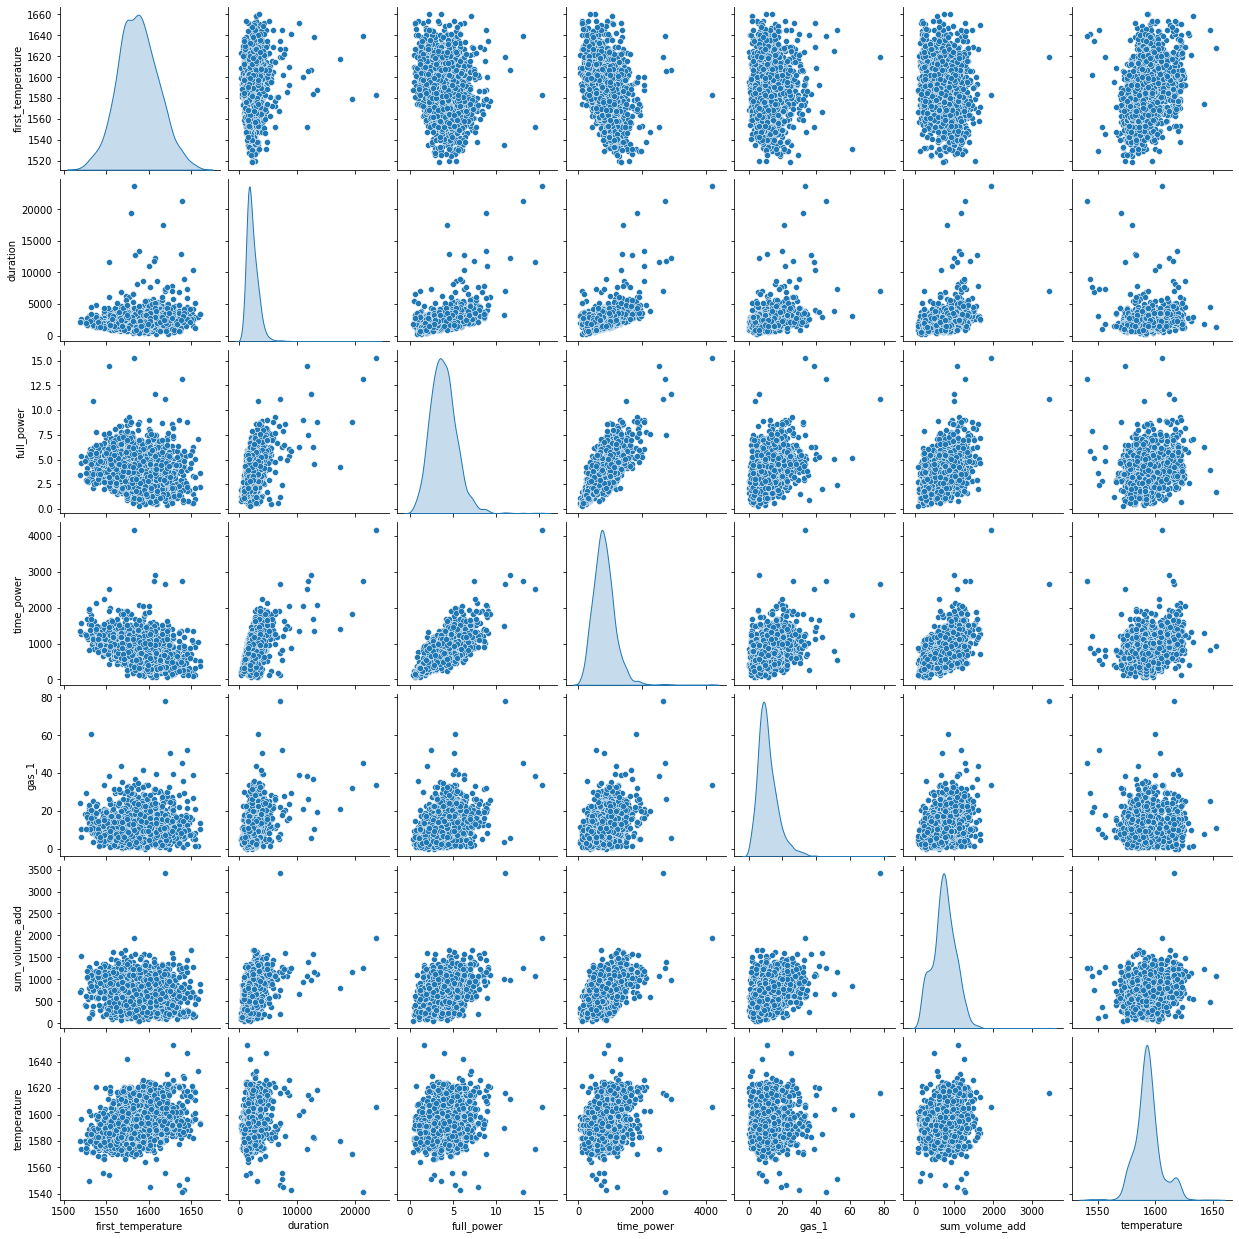

In [110]:
sns.pairplot(
    data[['first_temperature','duration','full_power','time_power','gas_1', 'sum_volume_add','temperature']], 
     diag_kind="kde"
)
plt.show()

Можно заметить, что некоторые признаки хорошо коррелируют между собой, такие, например, как суммарный объем присадок и полная мощность, время нагрева или объем газа

Посмотрим коэффициенты корреляции между основными признаками. Используем метод Спирмана, поскольку распределение рассматриваемых признаков близко к нормальному, но все-таки нормальным не является.

Метод Спирмена более универсален и менее строг, чем Пирсона. Точность Пирсона немного выше, но в нашем случае его точности должно быть достаточно.

In [111]:
data.corr(method='spearman')

key  temperature  first_temperature  duration  \
key                1.000000    -0.102895          -0.029093 -0.059500   
temperature       -0.102895     1.000000           0.307707  0.165442   
first_temperature -0.029093     0.307707           1.000000  0.268259   
duration          -0.059500     0.165442           0.268259  1.000000   
active_power      -0.033341     0.168681          -0.164218  0.540725   
full_power        -0.032258     0.167502          -0.163145  0.540920   
reactive_power    -0.030286     0.164319          -0.160686  0.537295   
time_power        -0.035728     0.237183          -0.418636  0.496729   
gas_1             -0.027278     0.042863           0.031194  0.471027   
sum_volume_add    -0.021348     0.220487          -0.072746  0.352375   
bulk_1            -0.062547    -0.046423           0.065093  0.131613   
bulk_3             0.028804    -0.035758          -0.113053  0.040469   
bulk_4            -0.019500     0.235004           0.192306  0.027880   
bulk_6             0.027124    -0.264062          -0.171723  0.098648   
bulk_10            0.040165     0.048489           0.034531 -0.008349   
bulk_11            0.091814    -0.119677          -0.098865  0.028862   
bulk_12            0.044841     0.240585          -0.074767  0.221061   
bulk_14           -0.139519     0.063999          -0.161626  0.235270   
bulk_15            0.024033     0.226705          -0.063870  0.102316   
wire_1            -0.015441     0.298333           0.270435  0.252014   
wire_2             0.049759    -0.234442          -0.111170  0.036105   

                   active_power  full_power  reactive_power  time_power  \
key                   -0.033341   -0.032258       -0.030286   -0.035728   
temperature            0.168681    0.167502        0.164319    0.237183   
first_temperature     -0.164218   -0.163145       -0.160686   -0.418636   
duration               0.540725    0.540920        0.537295    0.496729   
active_power           1.000000    0.998815        0.990990    0.681321   
full_power             0.998815    1.000000        0.996253    0.679932   
reactive_power         0.990990    0.996253        1.000000    0.673287   
time_power             0.681321    0.679932        0.673287    1.000000   
gas_1                  0.369866    0.370510        0.369097    0.376215   
sum_volume_add         0.382703    0.382299        0.379102    0.533149   
bulk_1                 0.064402    0.063173        0.060812    0.080393   
bulk_3                 0.095252    0.094387        0.091468    0.087407   
bulk_4                 0.003154    0.003103        0.003411   -0.055249   
bulk_6                 0.080068    0.080312        0.081119    0.126876   
bulk_10                0.003579    0.002879        0.000995   -0.019938   
bulk_11                0.046006    0.046824        0.047977    0.066808   
bulk_12                0.252338    0.252952        0.252345    0.434566   
bulk_14                0.274626    0.273912        0.271379    0.440429   
bulk_15                0.154449    0.153743        0.151302    0.297343   
wire_1                 0.139145    0.139293        0.139083    0.042274   
wire_2                 0.028455    0.027272        0.024511    0.023346   

                      gas_1  sum_volume_add  ...    bulk_3    bulk_4  \
key               -0.027278       -0.021348  ...  0.028804 -0.019500   
temperature        0.042863        0.220487  ... -0.035758  0.235004   
first_temperature  0.031194       -0.072746  ... -0.113053  0.192306   
duration           0.471027        0.352375  ...  0.040469  0.027880   
active_power       0.369866        0.382703  ...  0.095252  0.003154   
full_power         0.370510        0.382299  ...  0.094387  0.003103   
reactive_power     0.369097        0.379102  ...  0.091468  0.003411   
time_power         0.376215        0.533149  ...  0.087407 -0.055249   
gas_1              1.000000        0.328590  ...  0.058507 -0.009119   
sum_volume_add     0.328590        1.000000  .

**Итого:**
- Потребуется кодирование категориальных признаков для карты сплава, если она будет участвовать в обучении. Все остальные признаки потребуется масштабировать.

- Лучше всего заметна связь между:
    - полной затраченной мощностью и временем нагрева
    - полной мощностью и длительностью процесса создания партии сплава
    - временем нагрева и объемом легирующих веществ
    - временем нагрева и длительностью процесса 
    - длительностью процесса и объемом затраченного газа

- Некоторая корреляция заметна между конечной температурой и начальной, между конечной температурой и временем нагрева, а также между кончной температурой и объемом легирующих веществ, что вполне логично. Также заметна связь между целевым признаком и присадками 'wire_1', 'bulk_6', 'bulk_12', 'bulk_4', 'wire_2' и 'bulk_15'

In [112]:
#Сделаем номер партии индексом
data = data.set_index('key')

### Итого

- Все исходные датафреймы успешно объединены
- Добавлены дополнительные признаки:
    - Исходная температура
    - Длительность процесса создания сплава
    - `Карта присадок' - категориальный признак, состоящий из условного обозначения присадок с учетом порядка их добавления
    - Суммарный объем присадок
- Мощность (активная, реактивная и полная), расходуемая при нагреве расплава была просуммирована для каждой партии сплава.
- Признаки с объемами легирующих веществ были добавлены только для присадок, которые использовались в 95% сплавов.
- Потребуется кодирование категориальных признаков для карты сплава, если она будет участвовать в обучении. Все остальные признаки потребуется масштабировать
- Поскольку в итоговом датафрейме содержатся не только числовые признаки, но и один категориальный, рассмотрим далее отдельно корреляцию между признаками в разделе, посвещенном корреляционному анализу.

## Корреляционный анализ

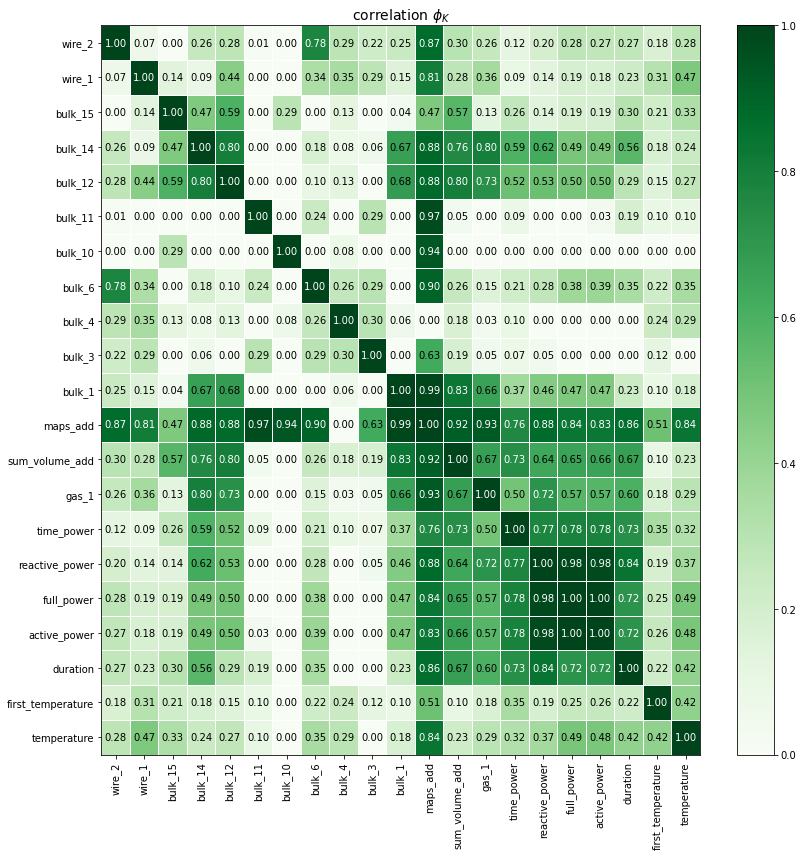

In [113]:
col_num = data.select_dtypes(include=np.number).columns.tolist()
#Посмотрим тепловую карту корреляций
phik_overview = data.phik_matrix(interval_cols=col_num)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    figsize=(12, 12)                       
)

Здесь получились немного другие коэффициенты корреляции, но в целом картина очень похожа. При этом самая большая корреляция целевого признака наблюдается с категориальным 'maps_add'. Возможно если бы он также содержал указание на объем присадки, то корреляция была бы еше больше.

### Итого

**Целевой признак** - `'temperature'`

**Самая хорошая корреляция** между целевым признаком и следующими входными признаками:
- `'maps_add'`, 0.84
- `'full_power'`, 0.49
- `'active_power'`, 0.48
- `'reactive_power'`, 0.37
- `'wire_1'`, 0.47
- `'duration'`, 0.42
- `'first_temperature'`, 0.42
- `'bulk_6'`, 0.35
- `'bulk_15'`, 0.33
- `'time_power'`, 0.32

Можно заметить, что новые добавленные признаки получились удачными, особенно хорошо с целевым признаком коррелирует признак `'maps_add'`. Кроме того, этот признак очень хорошо коррелирует с объемом легирующих веществ, и может заменить столбцы с этими признаками, но кроме того, он хорошо коррелирует  и с остальными признаками.

**Мультиколлинеарность**
Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки. 

В данном случае самая большая корреляция во входных признаках:
- между `'maps_add'`, `'bulk_1`, `'bulk_6'`, `'bulk_10'`, `'bulk_11'` и `'sum_volume_add'` коллинеарность от 0.9 до 0.99
- между `'active_power'`, `'reactive_power'` и `'full_power'` коллинеарность 0.98-1.00

Таким образом нужно удалять либо `'maps_add'`, либо `'bulk_1`, `'bulk_6'`, `'bulk_10'`, `'bulk_11'`. Поскольку корреляция входными между признаками может искажать результаты МО, уберем признак `'maps_add'`.

**Примечание:**

Были рассмотрены оба варианта перечней входных признаков, модель с `'maps_add'` вместо объемов загрузки присадок работает действительно немного хуже, наверное потому, что несет в себе перечни и порядок добавления присадок, но не несет информацию об их объеме легирующих веществ, а она более важная.

Удалим лишние признаки:

In [114]:
#data_new = data.drop(['bulk_1', 'bulk_6', 'bulk_10', 'bulk_11', 'sum_volume_add', 'active_power', 'reactive_power','gas_1'],axis = 1)

In [115]:
data_new = data.drop(['maps_add', 'active_power', 'reactive_power'],axis = 1)

## Обучение моделей

### Поделим выборку на тренировочную, валидационную и тестовую

In [116]:
#Запишем константы
RANDOM_STATE = 160924
TRAIN_SIZE = 0.75

In [117]:
X = data_new.drop(['temperature'], axis = 1)
y = data_new['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    train_size=TRAIN_SIZE,
    random_state = RANDOM_STATE)

In [118]:
#Посмотрим размеры созданных выборок входных признаков
X.shape, X_train.shape, X_test.shape

((2329, 17), (1746, 17), (583, 17))

In [119]:
#Посмотрим размеры созданных выборок целевых признаков
y.shape, y_train.shape, y_test.shape

((2329,), (1746,), (583,))

In [120]:
#Поделим колонки на числовые и категориальные
col_num = X.select_dtypes(include=np.number).columns.tolist()
print('Числовые признаки: ', col_num)

col_cat = X.select_dtypes(exclude=np.number).columns.tolist()
print('Категориальные признаки: ', col_cat)

Числовые признаки:  ['first_temperature', 'duration', 'full_power', 'time_power', 'gas_1', 'sum_volume_add', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2']
Категориальные признаки:  []


Напомню, что для лучшего обучения моделей при проведении исследовательского анализа предлагалось убрать все строки с объемом газа более 40, либо заменить в них объем газа на 'предельное значение' 40. Выберем второй вариант. Заменим такие значения в тренировочной выборке.

In [121]:
X_train.loc[X_train.query('gas_1>40').index,'gas_1']=40

На случай, если у модели на входе все-таки будут категориальные признаки (карта сплава), предусмотрим их кодирование BinaryEncoder

### Создадим пайплайн, подготовим данные и посмотрим простые модели

In [122]:
# создаём пайплайн для подготовки категориальных признаков
target_pipe = Pipeline([
    ('simpleImputer_before_target', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('target', ce.binary.BinaryEncoder()),
    #('scaler', StandardScaler()),
    ('simpleImputer_after_target', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])


# Создание общего пайплайна для подготовки данных
data_preprocessor = ColumnTransformer([
    ('target', target_pipe, col_cat),
    ('num', StandardScaler(), col_num)
], remainder='passthrough')

# Объединение в окончательный пайплайн шаг с подготовкой данных и инициализацией модели
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [123]:
#Гиперпараметры для линейной регрессии
param_grid_reg = [{
    'models' : [LinearRegression()],
    'models__fit_intercept': [True, False],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    }]

#Гиперпараметры для дерева регрессии
param_grid_tree = {
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
    'models__ccp_alpha': [0.001, 0.01, 0.1],
    'models__max_depth': range(3, 15),
    'preprocessor__num': ['passthrough']
}
    
#Гиперпараметры для  модели Ridge
param_grid_ridge = {
    'models': [Ridge(random_state=RANDOM_STATE)], 
    'models__alpha':[0.01, 1, 10],
    'preprocessor__num': [StandardScaler(), MinMaxScaler()]
}

#Параметры для модели RandomForestRegressor
model = RandomForestRegressor()
params_grid_forest = {
    'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__n_estimators': [10,50,100],
    'models__max_depth': range(5, 15, 3),
    'models__min_samples_split': range(2, 10,2),
    'models__bootstrap': [True, False],
    'preprocessor__num': [StandardScaler(), MinMaxScaler()]
}


In [124]:
m_name=[]
mae = []
best_model = []
fit_time = []
score_time = []

for m_param in [param_grid_reg, param_grid_tree, param_grid_ridge, params_grid_forest]:
    
    grid = GridSearchCV(
    pipe_final,
    param_grid=m_param,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    m_name.append(type(grid.best_estimator_.named_steps['models']).__name__)
    best_model.append(grid.best_estimator_)
    mae.append(round(-1*(grid.best_score_), 4))
    
    best_index = grid.best_index_
    cv_results = pd.DataFrame(grid.cv_results_)
    fit_time.append(cv_results.loc[best_index, 'mean_fit_time'])
    score_time.append(cv_results.loc[best_index, 'mean_score_time'])

In [125]:
pd.DataFrame({
    'MAE': mae, 
    'mean_fit_time':fit_time,
    'mean_score_time':score_time},
    index = m_name)

MAE  mean_fit_time  mean_score_time
LinearRegression       6.0617       0.036910         0.002774
DecisionTreeRegressor  7.5227       0.011152         0.001940
Ridge                  6.0540       0.054011         0.004672
RandomForestRegressor  6.1805       0.950970         0.013547

Можно заметить, что все простые модели кроме дерева регрессии хорошо справились с заданием, и их метрики удовлетворяют заявленным требованиям. Возможно, у дерева регрессии недостаточно хорошо были подобраны варианты для гиперпараметров.

Лучше всех справилась модель 'Ridge'. Она к тому же среди простых моделей в данном случае самая быстрая.

### Посмотрим, как работает LightGBM

In [126]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
for col in col_cat:
    X_train_lgbm[col]= X_train_lgbm[col].astype('category')
    X_test_lgbm[col]= X_test_lgbm[col].astype('category')

In [127]:
#Гиперпараметры для  модели LGBMRegressor
param_grid_lgbm = {
    'n_estimators' : [100, 1200]
}

In [128]:
model_lgbm = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_STATE,
    verbose=-1,
)

In [129]:
grid = GridSearchCV(
    model_lgbm,
    param_grid=param_grid_lgbm,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1)
    
grid.fit(X_train_lgbm, y_train)

m_name.append('LGBMRegressor')
best_model.append(grid.best_estimator_)
mae.append(round(-1*(grid.best_score_), 4))

best_index = grid.best_index_
cv_results = pd.DataFrame(grid.cv_results_)
fit_time.append(cv_results.loc[best_index, 'mean_fit_time'])
score_time.append(cv_results.loc[best_index, 'mean_score_time'])

In [130]:
print('Лучшая модель LGBMRegressor:', best_model[-1]),
print('Метрика данной модели на тренировочной выборке:', mae[-1])

Лучшая модель LGBMRegressor: LGBMRegressor(learning_rate=0.05, max_depth=5, objective='regression',
              random_state=160924, verbose=-1)
Метрика данной модели на тренировочной выборке: 6.1611


В данном случае модель 'LGBMRegressor' справилась достаточно хорошо, метрика 'MAE' удовлетворяет требованиям, но обычная линейная регрессия 'LinearRegression' и 'Ridge' с нашими исходными данными справились лучше.

### Посмотрим, как работает CatBoost

In [131]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()
for col in col_cat:
    X_train_cb[col]= X_train_cb[col].fillna('unknow')
    X_test_cb[col]= X_test_cb[col].fillna('unknow')


train_dataset = Pool(X_train_cb, y_train, cat_features=col_cat)
test_dataset = Pool(X_test_cb, y_test, cat_features=col_cat)

In [132]:
#Гиперпараметры для  модели CatBoostRegressor
param_grid_cb = {
    'iterations': [100, 500, 1200],
    'depth': range(2,7,2),
    'learning_rate': [0.01,0.05,0.1]
}

In [133]:
model_cb = CatBoostRegressor(
    loss_function='MAE',
    #learning_rate=0.05,
    random_state=RANDOM_STATE,
    cat_features=col_cat    
)

In [134]:
grid = GridSearchCV(
    model_cb,
    param_grid=param_grid_cb,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1)
    
grid.fit(X_train_cb,y_train)

m_name.append('CatBoostRegressor')
best_model.append(grid.best_estimator_.get_params())
mae.append(round(-1*(grid.best_score_), 4))

best_index = grid.best_index_
cv_results = pd.DataFrame(grid.cv_results_)
fit_time.append(cv_results.loc[best_index, 'mean_fit_time'])
score_time.append(cv_results.loc[best_index, 'mean_score_time'])


0:	learn: 8.0283514	total: 47.3ms	remaining: 4.69s
1:	learn: 8.0225378	total: 48.3ms	remaining: 2.37s
2:	learn: 8.0159334	total: 49ms	remaining: 1.58s
3:	learn: 8.0086026	total: 49.7ms	remaining: 1.19s
4:	learn: 7.9992062	total: 50.4ms	remaining: 957ms
5:	learn: 7.9916427	total: 51.1ms	remaining: 800ms
6:	learn: 7.9852484	total: 51.8ms	remaining: 688ms
7:	learn: 7.9781357	total: 52.5ms	remaining: 603ms
8:	learn: 7.9704764	total: 53.2ms	remaining: 538ms
9:	learn: 7.9625982	total: 53.9ms	remaining: 485ms
10:	learn: 7.9590159	total: 54.6ms	remaining: 442ms
11:	learn: 7.9481818	total: 55.3ms	remaining: 406ms
12:	learn: 7.9420966	total: 56ms	remaining: 375ms
13:	learn: 7.9352055	total: 56.7ms	remaining: 349ms
14:	learn: 7.9293259	total: 57.5ms	remaining: 326ms
15:	learn: 7.9248370	total: 58.1ms	remaining: 305ms
16:	learn: 7.9180395	total: 58.8ms	remaining: 287ms
17:	learn: 7.9116125	total: 59.6ms	remaining: 271ms
18:	learn: 7.9056616	total: 60.3ms	remaining: 257ms
19:	learn: 7.8992396	total

In [135]:
print('Лучшая модель CatBoostRegressor:', best_model[-1]),
print('Метрика данной модели на тренировочной выборке:', mae[-1])

Лучшая модель CatBoostRegressor: {'iterations': 1200, 'learning_rate': 0.05, 'depth': 2, 'loss_function': 'MAE', 'random_state': 160924, 'cat_features': []}
Метрика данной модели на тренировочной выборке: 5.9197


Посмотрим параметры лучшей модели 'CatBoostRegressor'

In [136]:
param_cb = best_model[-1]
param_cb

{'iterations': 1200,
 'learning_rate': 0.05,
 'depth': 2,
 'loss_function': 'MAE',
 'random_state': 160924,
 'cat_features': []}

### Сравним все самые лучшие подобранные модели

In [137]:
pd.DataFrame({
    'MAE': mae, 
    'mean_fit_time':fit_time,
    'mean_score_time':score_time},
    index = m_name)

MAE  mean_fit_time  mean_score_time
LinearRegression       6.0617       0.036910         0.002774
DecisionTreeRegressor  7.5227       0.011152         0.001940
Ridge                  6.0540       0.054011         0.004672
RandomForestRegressor  6.1805       0.950970         0.013547
LGBMRegressor          6.1611       0.494389         0.056548
CatBoostRegressor      5.9197       1.700855         0.002675

- Практически все модели, кроме дерева регрессии отлично справились с заданием. Пороговое значение требуемой метрики `'MAE'` не более 6.8

- Лучше всех справилась модель `'CatBoostRegressor'`. Кроме того, у нее не самое быстрое время обучения, но практически самое быстрое время предсказания.

Напомню параметры лучшей модели:

In [138]:
param_cb

{'iterations': 1200,
 'learning_rate': 0.05,
 'depth': 2,
 'loss_function': 'MAE',
 'random_state': 160924,
 'cat_features': []}

In [139]:
#Создадим модель
model_cb = CatBoostRegressor(
    learning_rate=0.05,
    loss_function='MAE',
    random_state=RANDOM_STATE,
    #cat_features=['maps_add'],
    depth=2,
    iterations = 1200,
    )

model_cb.fit(X_train, y_train)
predict = model_cb.predict(X_test)
mae_test = mean_absolute_error(y_test, predict)

0:	learn: 7.9979944	total: 963us	remaining: 1.16s
1:	learn: 7.9614681	total: 2ms	remaining: 1.2s
2:	learn: 7.9271989	total: 2.88ms	remaining: 1.15s
3:	learn: 7.8999927	total: 3.68ms	remaining: 1.1s
4:	learn: 7.8708402	total: 4.47ms	remaining: 1.07s
5:	learn: 7.8380360	total: 5.17ms	remaining: 1.03s
6:	learn: 7.8132100	total: 5.98ms	remaining: 1.02s
7:	learn: 7.7766448	total: 6.77ms	remaining: 1.01s
8:	learn: 7.7432250	total: 7.53ms	remaining: 997ms
9:	learn: 7.7107575	total: 8.28ms	remaining: 985ms
10:	learn: 7.6855410	total: 9.08ms	remaining: 981ms
11:	learn: 7.6398674	total: 9.87ms	remaining: 977ms
12:	learn: 7.6142468	total: 10.6ms	remaining: 969ms
13:	learn: 7.5804105	total: 11.5ms	remaining: 975ms
14:	learn: 7.5593687	total: 12.3ms	remaining: 971ms
15:	learn: 7.5307087	total: 13.1ms	remaining: 972ms
16:	learn: 7.5107236	total: 13.9ms	remaining: 967ms
17:	learn: 7.4877425	total: 14.7ms	remaining: 964ms
18:	learn: 7.4682245	total: 15.4ms	remaining: 960ms
19:	learn: 7.4478624	total: 

In [140]:
print('Метрика MAE для выбранной модели на тестовой выборке:', round(mae_test,4))

Метрика MAE для выбранной модели на тестовой выборке: 5.7591


### Проверим адекватность модели на дамми-регрессоре

In [141]:
#Проверим лучшую модель на DummyRegressor
dummy_reg = DummyRegressor()
dummy_reg.fit(X_train, y_train)
dummy_pred = dummy_reg.predict(X_test)
print(
    'Метрика MAE модели Дамми-регрессора на тестовой выборке:',
    round(mean_absolute_error(y_test, dummy_pred),4)
)

Метрика MAE модели Дамми-регрессора на тестовой выборке: 8.1922


Наша лучшая модель прошла проверку на 'DummyRegressor'

### Проведем анализ остатков

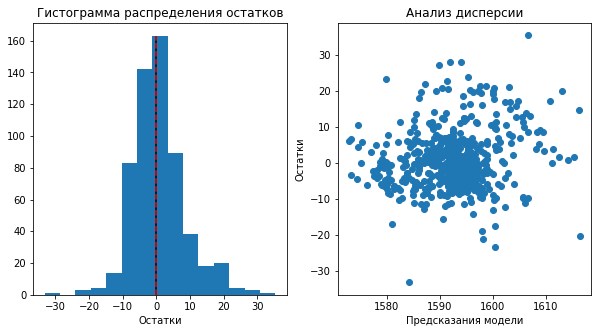

In [142]:
#Посчитаем остатки
res = y_test-predict
#Построим графики: по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
bins=axes[0].hist(res,bins=15)
axes[0].vlines(x=0, colors='black', ymin=0, ymax=bins[0].max(), label='Среднее')
axes[0].vlines(x=res.median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')

axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
    
axes[1].scatter(x=predict,y=res)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

- В данном случае распределение остатков близкое к нормальному, но немного смещено вправо. Это говорит о том, что модель недооценивает реальные значения целевого признака, её прогнозы меньше фактических показателей. При этом смещение совсем небольшое.
- Разница между минимумом и максимумом остатков при любых прогнозных значениях модели практически не меняется. Дисперсия между значениями на оси Y постоянна на протяжении всей оси X. Это говорит о высоком качестве модели, поскольку она достаточно равномерно ошибается.

### Итого

- Итоговый объединенный датафрейм был поделен на тестовую и тренировочную выборки в соотношении 3:1, тренировочная выборка была доболнительно предобработана - все значения объема газа более 40 были заменены на 40.
- Рассмотрены различные модели модели МО. Практически все модели, кроме дерева регрессии, отлично справились с заданием.
- Была выбрана модель с наименьшим значением 'MAE' на тренировочной выборке, это `'CatBoostRegressor'`. Кроме того, у нее не самое быстрое время обучения, но практически самое быстрое время предсказания. Для выбранной модели значение 'MAE' на тренировочной выборке составляет 5.9197. Параметры выбранной модели:
    - 'iterations': 1200
    - 'learning_rate': 0.05
    - 'depth': 2
    - 'loss_function': 'MAE'
    - 'random_state': 160924
    - 'cat_features': []
- Метрика 'MAE' для выбранной модели на тестовой выборке составляет 5.7591, что удовлетворяет поставленным условиям -'MAE' не более 6.8.
- Адекватность выбранной модели проверена на Дамми-регрессоре, модель проверку прошла.
- Проведен анализ остатков. Для выбранной модели распределение остатков близкое к нормальному, но немного смещено вправо. Это говорит о том, что модель недооценивает реальные значения целевого признака, её прогнозы могут быть меньше фактических показателей. При этом смещение совсем небольшое.Разница между минимумом и максимумом остатков при любых прогнозных значениях модели практически не меняется. Это говорит о достаточно высоком качестве модели, поскольку она достаточно равномерно ошибается.

## Анализ важности признаков

### Посмотрим распределение важности признаков

In [143]:
#Посмотрим распределение важности признаков
pd.DataFrame(
    {"feature": X_train_cb.columns, "importance": model_cb.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

feature  importance
0          time_power   28.578285
1   first_temperature   21.817614
2            duration   11.066259
3              bulk_6    7.480145
4              wire_1    6.397064
5              wire_2    4.784265
6             bulk_14    3.461485
7             bulk_12    2.743886
8             bulk_15    2.706529
9               gas_1    2.399148
10             bulk_1    2.317356
11             bulk_4    1.593141
12     sum_volume_add    1.571279
13         full_power    1.385868
14            bulk_11    1.112427
15             bulk_3    0.470430
16            bulk_10    0.114819

Можно заметить, что:
- Больше всего влияет на конечную температуру время нагрева.
- Также конечная температура существенно зависит от начальной температуры
- Зависит также конечная температура и от длительности процесса
- Зависимость конечной температуры от добавляемых присадок распределена следующим образом (от большего к меньшему):
    - 'bulk_6'
    - 'wire_1'
    - 'wire_2'
    - 'bulk_15'
    
    Видимо, эти присадки имеют большую температуру плавления.

Остальные признаки влияют на конечную температуру заметно меньше.

### Используем SHAP для анализа признаков

In [144]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer(X_train_cb)

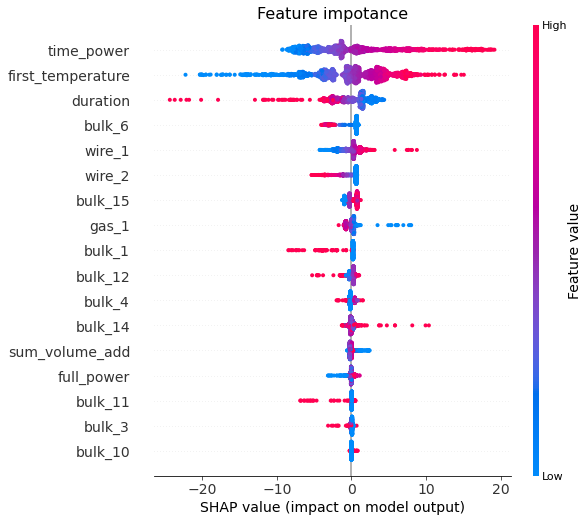

In [145]:
shap.plots.beeswarm(shap_values,max_display=20,show=False)
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize = 14)
ax.set_title('Feature impotance', fontdict={"size":16})
ax.set_xlabel('SHAP value (impact on model output)',fontdict={"size":14})

cb_ax = fig.axes[1]
cb_ax.set_ylabel('Feature value',fontdict={"size":14})
plt.show()

Признаки распределились достаточно однозначно, это говорит о том, что модель работает адекватно.

Можно заметить, что зависимость температуры от одних входных признаков прямая, а от других - обратная.

**Прямая зависимость:**
1. Больше всего конечная температура зависит от времени нагрева. И это логично: чем больше сплав греть, тем больше будет конечная температура.
2. Также конечная температура существенно зависит от начальной, чем выше исходная температура, тем выше результирующая.
3. Для загрузок 'wire_1', 'bulk_14', 'bulk_15', а также в меньшей мере для 'bulk_10', зависимость конечной температуры от объема присадки прямая. Можно предположить, что данные легирующие вещества имеют более высокую температуру плавления.
4. Также прямая зависимость между конечной температурой и полной можностью, явно видно, что чем меньше полная мощность, тем меньше конечная температура, что естественно - чтобы нагреть расплав, нужно затратить какую-то мощность.

**Обратная зависимость:**
1. В свою очередь зависимость итоговой температуры от длительности процесса обратная - чем дольше процесс плавления, тем ниже итоговая температура. Так или иначе, сплав остывает.
2. Зависимость конечной температуры от добавленного объема газа обратная. Судя по всему, добавление газа охлаждает расплав.
3. Конечная температура также зависит и от обхего объема присадок - чем он больше, тем меньше конечная температура. Вероятно, это может быть связано с продувкой после добавления присадок.
4. Для загрузок 'bulk_1', 'wire_2', 'bulk_11', 'bulk_12', 'bulk_3' и 'bulk_6', зависимость зависимость конечной температуры от объема присадки обратная. Видимо данные легирующие вещества не требуют повышенных температур для добавления их в состав сплава, скорее наоборот.

**Нет однозначной зависимости** между конечной температурой и объемом присадки 'bulk_4'

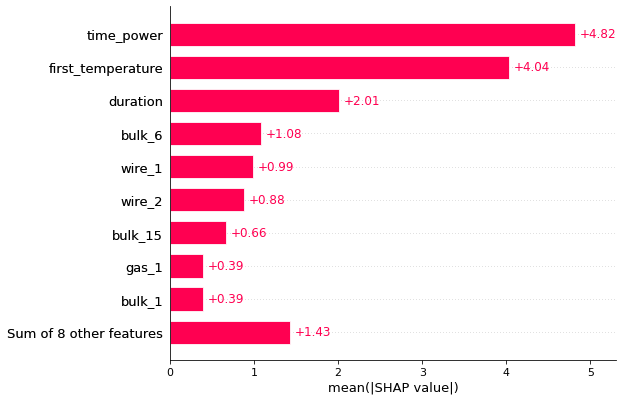

In [146]:
#Посмотрим распределение признаков по их важности
shap.plots.bar(shap_values)

Здесь распределение признаков по важности практически то же, но вместо объема загрузки в 'bulk_14' объем загрузки в 'bulk_15' оказался немного более важным. Возможно дело в том, что зависимость конечной температуры от объема 'bulk_15' более однозначно выражена.

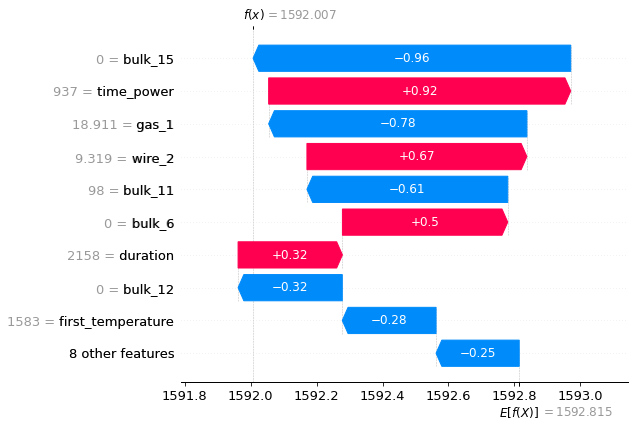

In [147]:
#Посмотрим информацию о случайной партии сплава
shap.plots.waterfall(shap_values[1000])

**Посмотрим сплав под номером 1000:**

В этом сплаве совсем не добавляются легирующие вещества из загрузок 'bulk_15', 'bulk_6' и 'bulk_12', но добавляется 'wire_2' и 'bulk_11'. При не самой высокой исходной температуре, 1583 градуса, итоговая температура оказалась тоже немного ниже средней, она оказалась 1592.007 градуса. В процессе производства расплав нагревался достаточно длительное время, дольше обычного, но длительность процесса также была немного выше среднего, и было использовано достаточно много газа.

Для данного сплава больший вклад в величину итоговой темпераутры внесли:
- состав сплава (особенно отсутствие 'bulk_11', наличие 'wire_2' и достаточно большой объем 'bulk_11')
- объем газа для продувки
- длительность нагрева

**Таким образом можно рассматривать любые партии сплавов, если будет необходимо повторно выплавлять какую-то марку стали**

### Итого

- Больше всего влияют на конечную температуру время нагрева, конечная температура и длительность процесса производства.
- Зависимость конечной температуры от добавляемых присадок распределена следующим образом (от большего к меньшему):
    - 'bulk_6'
    - 'wire_1'
    - 'wire_2'
    - 'bulk_15'
    
    Видимо, эти присадки имеют большую температуру плавления.
- Остальные признаки влияют на конечную температуру заметно меньше.
- Признаки распределились достаточно однозначно, это говорит о том, что модель работает адекватно.
- Зависимость температуры от одних входных признаков прямая, а от других - обратная.
    - Прямая зависимость наблюдается между конечной температурой и временем нагрева, исходной температурой, затраченной мощностью и объемом загрузки присадок 'wire_1', 'bulk_14', 'bulk_15', а также в меньшей мере для 'bulk_10'
    - Обратная зависимость наблюдается между конечной температурой и длительностью процесса выплавления партии, объемом добавляемого газа при продувке, общим объемом добавляемых присадок и объемом добавляемых легирующих веществ 'bulk_1', 'wire_2', 'bulk_11', 'bulk_12', 'bulk_3' и 'bulk_6'
- При необходимости можно подробно рассмотреть любую влияние факторов на сплав из любой партии, присутствующей в исходных данных и включенной в анализ

## Общий вывод

### Исходные данные

Исследование проводится для металлургического комбината "Стальная Птица". Оно потребуется для контроля и реализации возможного уменьшения потребления электроэнергии на этапе обработки стали. Для этого комбинату необходимо контролировать температуру сплава.

**Цель исследования:**
- Построить модель, которая сможет предсказать температуру сплава на этапе обработки стали. Модель потребуется для имитации технологического процесса.

### Исходные данные потребовали предварительной обработки, а именно:

- Названия столбцов у всех датафреймов для удобства обработки были приведены к змеиному шрифту
- Типы данных в столбцах датафреймов были приведены в соответствие с их содержимым. Кроме того, данные типа `'float64'` и `'int64'` были приведены к `'float32'` и `'int32'` соответственно.
- Все датафреймы не содержат дубликаты, но некоторые из них содержат пропуски, пропуски были обработаны на этапе объединения датафреймов.
- Некоторые столбцы в датафреймах `'data_bulk_new'`, `'data_bulk_time_new'`, `'data_wire_new'` и `'data_wire_time_new'` содержат крайне мало заполненных значений (менее 5%). Таки столбцы будут малоинформативны при построении модели, поэтому они были удалены.
- В датафрейме `'data_temp_new'` также содержалось значительное количество пропусков в столбце с температурой. Поскольку этот столбец является целевым признаком, то строки с пропусками в данном столбце пришлось удалить, несмотря на то, что их достаточно много.


### Проведен исследовательский анализ данных со следующими результатами

**Результаты анализа целевого признака:**
- Большая часть процессов требует нагрева до 1580-1599 градусов. Медианное значение 1590, а среднее - 1590.72.
- Распределение температур близкое к нормальному, с одним дополнительным пиком в области пониженных температур и двумя дополнительными пиками в области повышенных температур.
- Начиная с 10 августа 2019 года (14:13) наблюдаются нарушения в записи замеров температуры. Либо поменялась технология производства сплавов, либо возникли проблемы с работой термодатчиков. С этого момента не каждое значение времени замера соответствует температуре, в некоторые моменты времени температурные показания отсутствуют. Если это не намеренное отсутсвие замера температуры, то возможно возникло нарушение работоспособности одного из термодатчиков, либо нарушение в процессе записи данных.

**Статистика по входным признакам:**

- Большая часть операций легирования требует полной мощности от 0.578839 до 1.030402. медианное значение полной мощности составляет 0.746554, а среднее - 0.823384. Среднее значение мощности немного больше, поскольку часть операций требует повышенной мощности. При этом следует отметить, что после значений активной мощности порядка 0.7, активная мощность начинает немного больше превышать реактивную, кажется, что полезная работа совершается более эффективно. Кажется, что операции, на которые расходуется сравнительно больше активной мощности, могут быть более эффективными с точки зрения экономии электроэнергии. В среднем активная мощность больше реактивной, следовательно большая часть полной мощности все-таки расходуется на полезную работу.
- Большая часть операций требует от 107 до 214с нагрева, медианное значение - порядка 147с, а среднее больше - 171.67с нагрева. Такая разница возникает из-за того, что есть варианты легирования, при которых требуется более долгий нагрев сплава. Минимальное время нагрева составляет 11с, а максимальное - 907с.
- Большая часть операций требует объема газа от 7.04 до 13.77. медианное значение объема газа составляет 9.84, а среднее - 11.00 Среднее значение мощности существенно больше, поскольку часть операций требует сравнительно большего объема. Плотность распределения объема подаваемого газа больше похожа на распределение Пуассона, близкое к нормальному.
- По данным добавления легирующих веществ также было обнаружено изменение технологического процесса:
    - До определенного момента в загрузках 'bulk_14' и 'bulk_15' загружался объем сыпучих веществ, более 100 (примерно до 250) и кратный 50, заргузки ненормированного объема наблюдались реже. Менее 100 загружались сыпучие материалы в загрузках 'bulk_3' и 'bulk_4'. Кажется, что такие загрузки в целом не нормированы.
    - После определенного момента загрузки 'bulk_14' и 'bulk_15' начали более часто использоваться, и объем загружаемых в эти загрузки веществ практически перестал нормироваться.
    - Тот самый 'определенный момент' не совпадает с 10 августа, он наступил несколько раньше, а именно 28 июля 2019 года (начиная с 2111 партии).
    - При загрузке проволоки до определенного момента использовались в основном загрузки 'wire_1' и 'wire_2', крайне редко - 'wire_9', остальные загрузки практически не использовались. После 27 июля начали чаще использоваться загрузки 'wire_3'-'wire_8'.


**Исходные датафреймы были очищены от аномалий и дополнены:**
- Из нового датафрейма `'data_temp'`, были удалены строки с температурами менее 1300 С. Практически все процессы требуют нагрева от 1500 до 1700 С, температуры ниже 1300С кажутся аномальными, поскольку температура плавления стали 1300-1500 градусов по Цельсию.
- В датафрейме `'data_arc_new'` отрицательное значение реактивной мощности в одной строке было заменено на медианное значение реактивной мощности среди партий, активная мощность процессов плавления которых была близка по значению.
- Создан новый датафрейм `'data_arc'`, включающий в себя дополнительные признаки `'full_power'` (полная мощность) и `'time_power'` (время нагрева в с), из которого были удалены столбцы с началом и окончанием нагрева.
- Значения объемов подаваемого газа больше 40 больше похожи на выбросы. После разделения итогового датасета на тренировочную и тестовую выборку такие значения в тренировочной выборке были заменен на 'пороговое' - 40.

### Объединены исходные датафреймы в один, созданы дополнительные признаки и проведен анализ итогового датафрейма

- Все исходные датафреймы успешно объединены
- Добавлены дополнительные признаки:
    - Исходная температура
    - Длительность процесса создания сплава
    - `Карта присадок' - категориальный признак, состоящий из условного обозначения присадок с учетом порядка их добавления
    - Суммарный объем присадок
- Мощность (активная, реактивная и полная), расходуемая при нагреве расплава была просуммирована для каждой партии сплава.
- Признаки с объемами легирующих веществ были добавлены только для присадок, которые использовались в 95% сплавов.
- Потребуется кодирование категориальных признаков для карты сплава, если она будет участвовать в обучении. Все остальные признаки потребуется масштабировать
- Поскольку в итоговом датафрейме содержатся не только числовые признаки, но и один категориальный, корреляция между признаками была рассмотрена в разделе, посвещенном корреляционному анализу.

### Проведен корреляционный анализ данных со следующими результатами

**Целевой признак** - `'temperature'`

**Самая хорошая корреляция** между целевым признаком и следующими входными признаками:
- `'maps_add'`, 0.84
- `'full_power'`, 0.49
- `'active_power'`, 0.48
- `'reactive_power'`, 0.37
- `'wire_1'`, 0.47
- `'duration'`, 0.42
- `'first_temperature'`, 0.42
- `'bulk_6'`, 0.35
- `'bulk_15'`, 0.33
- `'time_power'`, 0.32

Можно заметить, что новые добавленные признаки получились удачными, особенно хорошо с целевым признаком коррелирует признак `'maps_add'`. Кроме того, этот признак очень хорошо коррелирует с объемом легирующих веществ, и может заменить столбцы с этими признаками, но кроме того, он хорошо коррелирует  и с остальными признаками.

**Мультиколлинеарность**
Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки. 

В данном случае самая большая корреляция во входных признаках:
- между `'maps_add'`, `'bulk_1`, `'bulk_6'`, `'bulk_10'`, `'bulk_11'` и `'sum_volume_add'` коллинеарность от 0.9 до 0.99
- между `'active_power'`, `'reactive_power'` и `'full_power'` коллинеарность 0.98-1.00

Таким образом нужно удалять либо `'maps_add'`, либо `'bulk_1`, `'bulk_6'`, `'bulk_10'`, `'bulk_11'`. Поскольку корреляция входными между признаками может искажать результаты МО, уберем признак `'maps_add'`.

**Примечание:**

Были рассмотрены оба варианта перечней входных признаков, модель с `'maps_add'` вместо объемов загрузки присадок работает действительно немного хуже, наверное потому, что несет в себе перечни и порядок добавления присадок, но не несет информацию об их объеме легирующих веществ, а она оказалось более важной.

### Созданы и обучены регрессионные модели МО со следующими результатами:

- Рассмотрены различные модели модели МО. Практически все модели, кроме дерева регрессии, отлично справились с заданием.

In [148]:
pd.DataFrame({
    'MAE': mae, 
    'mean_fit_time':fit_time,
    'mean_score_time':score_time},
    index = m_name)

MAE  mean_fit_time  mean_score_time
LinearRegression       6.0617       0.036910         0.002774
DecisionTreeRegressor  7.5227       0.011152         0.001940
Ridge                  6.0540       0.054011         0.004672
RandomForestRegressor  6.1805       0.950970         0.013547
LGBMRegressor          6.1611       0.494389         0.056548
CatBoostRegressor      5.9197       1.700855         0.002675

- Была выбрана модель с наименьшим значением 'MAE' на тренировочной выборке, это `'CatBoostRegressor'`. Кроме того, у нее не самое быстрое время обучения, но практически самое быстрое время предсказания. Для выбранной модели значение 'MAE' на тренировочной выборке составляет 5.9197. Параметры выбранной модели:

In [149]:
param_cb

{'iterations': 1200,
 'learning_rate': 0.05,
 'depth': 2,
 'loss_function': 'MAE',
 'random_state': 160924,
 'cat_features': []}

- Метрика 'MAE' для выбранной модели на тестовой выборке составляет 5.7591, что удовлетворяет поставленным условиям -'MAE' не более 6.8.
- Адекватность выбранной модели проверена на Дамми-регрессоре, модель проверку прошла.
- Проведен анализ остатков. Для выбранной модели распределение остатков близкое к нормальному, но немного смещено вправо. Это говорит о том, что модель недооценивает реальные значения целевого признака, её прогнозы могут быть меньше фактических показателей. При этом смещение совсем небольшое.Разница между минимумом и максимумом остатков при любых прогнозных значениях модели практически не меняется. Это говорит о достаточно высоком качестве модели, поскольку она достаточно равномерно ошибается.

### Проведен анализ важности признаков со следующими результатами:

- Больше всего влияют на конечную температуру время нагрева, конечная температура и длительность процесса производства.
- Зависимость конечной температуры от добавляемых присадок распределена следующим образом (от большего к меньшему):
    - 'bulk_6'
    - 'wire_1'
    - 'wire_2'
    - 'bulk_15'
    
    Видимо, эти присадки имеют большую температуру плавления.
- Остальные признаки влияют на конечную температуру заметно меньше.
- Признаки распределились достаточно однозначно, это говорит о том, что модель работает адекватно.
- Зависимость температуры от одних входных признаков прямая, а от других - обратная.
    - Прямая зависимость наблюдается между конечной температурой и временем нагрева, исходной температурой, затраченной мощностью и объемом загрузки присадок 'wire_1', 'bulk_14', 'bulk_15', а также в меньшей мере для 'bulk_10'
    - Обратная зависимость наблюдается между конечной температурой и длительностью процесса выплавления партии, объемом добавляемого газа при продувке, общим объемом добавляемых присадок и объемом добавляемых легирующих веществ 'bulk_1', 'wire_2', 'bulk_11', 'bulk_12', 'bulk_3' и 'bulk_6'
- При необходимости можно подробно рассмотреть любую влияние факторов на сплав из любой партии, присутствующей в исходных данных и включенной в анализ

### Рекомендации

- По исходным данным была восстановлена последовательность техпроцессов производства стали двух временных периодов - до 10 августа 2019 года и после 10 августа 2019 года. Было обнаружено нарушение техпроцесса после 10 августа 2019 года, а именно:  первое и единственное измерение температуры производилось в самом начале процесса производства, дальнейшие замеры температуры не фиксировались. Возможно произошел отказ соответствующих термодатчиков либо отказ в системе записи данных. Рекомендуется проверить работоспособность температурных датчиков и корректность процессов записи температуры.
- Помимо нарушения процесса фиксации температуры также было обнаружено изменение процессов добавления легирующих веществ, которое наблюдается с 28 июля 2019 года (партия 2111). Рекомендуется обратить внимание на объемы загружаемых сыпучих веществ в загрузках 'bulk_14' и 'bulk_15' и проволоки в загрузках 'wire_3'-'wire_8'. Если не было значительных изменений в марках сплавов данных партий, возможно был нарушен процесс загрузки присадок.
- Из-за нарушения процесса контролирования температурных режмов при изготовлении стали могли произойти нарушения температурных режимов создания сплавов определенного состава. Рекомендуется уточнить, был ли произведен контроль химического состава и качества (технических характеристик) выплавляемых заготовок.

**Примечание:**
Все данные о партиях 2500 и старше придется исключить из дальнейшего анализа.